In [ ]:
# Installing required libraries
!pip install tensorflow
!pip install xgboost

In [ ]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from math import sqrt
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt

%matplotlib inline

In [ ]:



from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:



# Load energy data
energy_df = pd.read_csv(r"/content/drive/MyDrive/combined_ds/energy_dataset.csv", parse_dates=['time'], index_col='time')

# Load weather datat
weather_df = pd.read_csv(r"/content/drive/MyDrive/combined_ds/weather_features.csv", parse_dates=['dt_iso'], index_col='dt_iso')


In [ ]:
energy_df.head()

generation biomass  \
time                                            
2015-01-01 00:00:00+01:00               447.0   
2015-01-01 01:00:00+01:00               449.0   
2015-01-01 02:00:00+01:00               448.0   
2015-01-01 03:00:00+01:00               438.0   
2015-01-01 04:00:00+01:00               428.0   

                           generation fossil brown coal/lignite  \
time                                                              
2015-01-01 00:00:00+01:00                                 329.0   
2015-01-01 01:00:00+01:00                                 328.0   
2015-01-01 02:00:00+01:00                                 323.0   
2015-01-01 03:00:00+01:00                                 254.0   
2015-01-01 04:00:00+01:00                                 187.0   

                           generation fossil coal-derived gas  \
time                                                            
2015-01-01 00:00:00+01:00                                 0.0   
2015-01-01 01:00:00+01:00                                 0.0   
2015-01-01 02:00:00+01:00                                 0.0   
2015-01-01 03:00:00+01:00                                 0.0   
2015-01-01 04:00:00+01:00                                 0.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2015-01-01 00:00:00+01:00                 4844.0                       4821.0   
2015-01-01 01:00:00+01:00                 5196.0                       4755.0   
2015-01-01 02:00:00+01:00                 4857.0                       4581.0   
2015-01-01 03:00:00+01:00                 4314.0                       4131.0   
2015-01-01 04:00:00+01:00                 4130.0                       3840.0   

                           generation fossil oil  generation fossil oil shale  \
time                                                                            
2015-01-01 00:00:00+01:00                  162.0                          0.0   
2015-01-01 01:00:00+01:00                  158.0                          0.0   
2015-01-01 02:00:00+01:00                  157.0                          0.0   
2015-01-01 03:00:00+01:00                  160.0                          0.0   
2015-01-01 04:00:00+01:00                  156.0                          0.0   

                           generation fossil peat  generation geothermal  \
time                                                                       
2015-01-01 00:00:00+01:00                     0.0                    0.0   
2015-01-01 01:00:00+01:00                     0.0                    0.0   
2015-01-01 02:00:00+01:00                     0.0                    0.0   
2015-01-01 03:00:00+01:00                     0.0                    0.0   
2015-01-01 04:00:00+01:00                     0.0                    0.0   

                           generation hydro pumped storage aggregated  \
time                                                                    
2015-01-01 00:00:00+01:00                                         NaN   
2015-01-01 01:00:00+01:00                                         NaN   
2015-01-01 02:00:00+01:00                                         NaN   
2015-01-01 03:00:00+01:00                                         NaN   
2015-01-01 04:00:00+01:00                                         NaN   

                           generation hydro pumped storage consumption  \
time                                                                     
2015-01-01 00:00:00+01:00                                        863.0   
2015-01-01 01:00:00+01:00                                        920.0   
2015-01-01 02:00:00+01:00                                       1164.0   
2015-01-01 03:00:00+01:00                                       1503.0   
2015-01-01 04:00:00+01:00                                       1826.0   

                           generation hydro run-of-river 

In [ ]:

energy_df.index = pd.to_datetime(energy_df.index, utc=True).tz_localize(None)

In [ ]:
# the energy_df has extra records from 2014 where as weather_df has values from 2015
# it would be ideal to remove the rows with the times that are not present in both dataframes
energy_df = energy_df[energy_df.index.year >=2015]


In [ ]:
weather_df.head()

city_name     temp  temp_min  temp_max  pressure  \
dt_iso                                                                       
2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

                           humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
dt_iso                                                                        
2015-01-01 00:00:00+01:00        77           1        62      0.0      0.0   
2015-01-01 01:00:00+01:00        77           1        62      0.0      0.0   
2015-01-01 02:00:00+01:00        78           0        23      0.0      0.0   
2015-01-01 03:00:00+01:00        78           0        23      0.0      0.0   
2015-01-01 04:00:00+01:00        78           0        23      0.0      0.0   

                           snow_3h  clouds_all  weather_id weather_main  \
dt_iso                                                                    
2015-01-01 00:00:00+01:00      0.0           0         800        clear   
2015-01-01 01:00:00+01:00      0.0           0         800        clear   
2015-01-01 02:00:00+01:00      0.0           0         800        clear   
2015-01-01 03:00:00+01:00      0.0           0         800        clear   
2015-01-01 04:00:00+01:00      0.0           0         800        clear   

                          weather_description weather_icon  
dt_iso                                                      
2015-01-01 00:00:00+01:00        sky is clear          01n  
2015-01-01 01:00:00+01:00        sky is clear          01n  
2015-01-01 02:00:00+01:00        sky is clear          01n  
2015-01-01 03:00:00+01:00        sky is clear          01n  
2015-01-01 04:00:00+01:00        sky is clear          01n

# energy_df

In [ ]:
energy_df.head()

generation biomass  generation fossil brown coal/lignite  \
time                                                                            
2015-01-01 00:00:00               449.0                                 328.0   
2015-01-01 01:00:00               448.0                                 323.0   
2015-01-01 02:00:00               438.0                                 254.0   
2015-01-01 03:00:00               428.0                                 187.0   
2015-01-01 04:00:00               410.0                                 178.0   

                     generation fossil coal-derived gas  \
time                                                      
2015-01-01 00:00:00                                 0.0   
2015-01-01 01:00:00                                 0.0   
2015-01-01 02:00:00                                 0.0   
2015-01-01 03:00:00                                 0.0   
2015-01-01 04:00:00                                 0.0   

                     generation fossil gas  generation fossil hard coal  \
time                                                                      
2015-01-01 00:00:00                 5196.0                       4755.0   
2015-01-01 01:00:00                 4857.0                       4581.0   
2015-01-01 02:00:00                 4314.0                       4131.0   
2015-01-01 03:00:00                 4130.0                       3840.0   
2015-01-01 04:00:00                 4038.0                       3590.0   

                     generation fossil oil  generation fossil oil shale  \
time                                                                      
2015-01-01 00:00:00                  158.0                          0.0   
2015-01-01 01:00:00                  157.0                          0.0   
2015-01-01 02:00:00                  160.0                          0.0   
2015-01-01 03:00:00                  156.0                          0.0   
2015-01-01 04:00:00                  156.0                          0.0   

                     generation fossil peat  generation geothermal  \
time                                                                 
2015-01-01 00:00:00                     0.0                    0.0   
2015-01-01 01:00:00                     0.0                    0.0   
2015-01-01 02:00:00                     0.0                    0.0   
2015-01-01 03:00:00                     0.0                    0.0   
2015-01-01 04:00:00                     0.0                    0.0   

                     generation hydro pumped storage aggregated  \
time                                                              
2015-01-01 00:00:00                                         NaN   
2015-01-01 01:00:00                                         NaN   
2015-01-01 02:00:00                                         NaN   
2015-01-01 03:00:00                                         NaN   
2015-01-01 04:00:00                                         NaN   

                     generation hydro pumped storage consumption  \
time                                                               
2015-01-01 00:00:00                                        920.0   
2015-01-01 01:00:00                                       1164.0   
2015-01-01 02:00:00                                       1503.0   
2015-01-01 03:00:00                                       1826.0   
2015-01-01 04:00:00                                       2109.0   

                     generation hydro run-of-river and poundage  \
time                                                              
2015-01-01 00:00:00                                      1009.0   
2015-01-01 01:00:00                                       973.0   
2015-01-01 02:00:00                                       949.0   
2015-01-01 03:00:00                                       953.0   
2015-01-01 04:00:00                                       952.0   

                     generation hydro water reservoir  generation marine  \
tim

In [ ]:

energy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35063 entries, 2015-01-01 00:00:00 to 2018-12-31 22:00:00
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35044 non-null  float64
 1   generation fossil brown coal/lignite         35045 non-null  float64
 2   generation fossil coal-derived gas           35045 non-null  float64
 3   generation fossil gas                        35045 non-null  float64
 4   generation fossil hard coal                  35045 non-null  float64
 5   generation fossil oil                        35044 non-null  float64
 6   generation fossil oil shale                  35045 non-null  float64
 7   generation fossil peat                       35045 non-null  float64
 8   generation geothermal                        35045 non-null  float64
 9   generation hydro pumped storage aggre

Dropping columns with NaN values.

In [ ]:
# Dropping 2 columns due to NaN values.
energy_df.drop(['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead'], axis=1, inplace=True)

Dropping the columns with 0 values.

In [ ]:
# Confirming values of 6 columns are 0.
energy_df[['generation fossil coal-derived gas',
           'generation fossil oil shale',
           'generation fossil peat',
           'generation geothermal',
           'generation marine',
           'generation wind offshore']].value_counts()

generation fossil coal-derived gas  generation fossil oil shale  generation fossil peat  generation geothermal  generation marine  generation wind offshore
0.0                                 0.0                          0.0                     0.0                    0.0                0.0                         35044
Name: count, dtype: int64

In [ ]:
# Dropping 6 columns due to 0 values
energy_df.drop(['generation fossil coal-derived gas',
           'generation fossil oil shale',
           'generation fossil peat',
           'generation geothermal',
           'generation marine',
           'generation wind offshore'], axis=1, inplace=True)

In [ ]:
# checking for duplicate values
energy_df.index.has_duplicates

False

## Forecast Dataframe

creating forecast dataframe and adding columns like 'forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast TSO', 'price day ahead' from energy dataframe to forecast dataframe.

In [ ]:
forecast=pd.DataFrame(energy_df[['total load forecast',
                                'price day ahead']])
forecast.head()

total load forecast  price day ahead
time                                                     
2015-01-01 00:00:00              24934.0            48.10
2015-01-01 01:00:00              23515.0            47.33
2015-01-01 02:00:00              22642.0            42.27
2015-01-01 03:00:00              21785.0            38.41
2015-01-01 04:00:00              21441.0            35.72

In [ ]:
forecast.index = pd.to_datetime(forecast.index, utc=True).tz_localize(None)

forecast.index.rename('hour', inplace=True)

In [ ]:
forecast.head()

total load forecast  price day ahead
hour                                                     
2015-01-01 00:00:00              24934.0            48.10
2015-01-01 01:00:00              23515.0            47.33
2015-01-01 02:00:00              22642.0            42.27
2015-01-01 03:00:00              21785.0            38.41
2015-01-01 04:00:00              21441.0            35.72

In [ ]:
new_index=forecast.index

In [ ]:
scaler = MinMaxScaler()
forecast = pd.DataFrame(scaler.fit_transform(forecast), columns=forecast.columns, index=new_index)

In [ ]:
forecast.head()

total load forecast  price day ahead
hour                                                     
2015-01-01 00:00:00             0.293279         0.460723
2015-01-01 01:00:00             0.232338         0.453017
2015-01-01 02:00:00             0.194846         0.402382
2015-01-01 03:00:00             0.158042         0.363755
2015-01-01 04:00:00             0.143268         0.336836

In [ ]:
target_datee=forecast.index[26305]


Deleting forecasted columns from energy dataframe

In [ ]:
# Dropping 4 columns from energy dataframe as we have moved them into new datframe called 'forecast'.
energy_df.drop(['forecast solar day ahead',
                'forecast wind onshore day ahead',
                'total load forecast',
                'price day ahead'], axis=1, inplace=True)

In [ ]:
# A total of 12 columns have been dropped.
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35063 entries, 2015-01-01 00:00:00 to 2018-12-31 22:00:00
Data columns (total 16 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35044 non-null  float64
 1   generation fossil brown coal/lignite         35045 non-null  float64
 2   generation fossil gas                        35045 non-null  float64
 3   generation fossil hard coal                  35045 non-null  float64
 4   generation fossil oil                        35044 non-null  float64
 5   generation hydro pumped storage consumption  35044 non-null  float64
 6   generation hydro run-of-river and poundage   35044 non-null  float64
 7   generation hydro water reservoir             35045 non-null  float64
 8   generation nuclear                           35046 non-null  float64
 9   generation other                     

Finding number of null values in each column of energy dataframe

In [ ]:
energy_df.isnull().sum()

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price actual                                    0
dtype: int64

We will use forward filling method to fill the null values in each column. We can see that all the null values are filled using forward fill.

In [ ]:
energy_df.fillna(method='ffill', inplace=True)
energy_df.isnull().sum()


generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load actual                              0
price actual                                   0
dtype: int64

### it seems that even after ffill or bfill we are still seeing some missing values and that implies

### the dataframe must have continous missing values so the above methods wouldnt work, we have to proceed with interpolation

In [ ]:
# Linear interpolation
energy_df.interpolate(method='linear', inplace=True)
energy_df.isna().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load actual                              0
price actual                                   0
dtype: int64

In [ ]:
energy_df.shape


(35063, 16)

In [ ]:
energy_df.describe()

generation biomass  generation fossil brown coal/lignite  \
count        35063.000000                          35063.000000   
mean           383.530987                            448.095314   
std             85.346999                            354.621219   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   

       generation fossil gas  generation fossil hard coal  \
count           35063.000000                 35063.000000   
mean             5622.727861                  4256.534524   
std              2201.585102                  1961.998960   
min                 0.000000                     0.000000   
25%              4126.000000                  2527.000000   
50%              4970.000000                  4475.000000   
75%              6429.000000                  5839.000000   
max             20034.000000                  8359.000000   

       generation fossil oil  generation hydro pumped storage consumption  \
count           35063.000000                                 35063.000000   
mean              298.345207                                   475.552948   
std                52.514072                                   792.300445   
min                 0.000000                                     0.000000   
25%               263.000000                                     0.000000   
50%               300.000000                                    68.000000   
75%               330.000000                                   616.000000   
max               449.000000                                  4523.000000   

       generation hydro run-of-river and poundage  \
count                                35063.000000   
mean                                   972.204090   
std                                    400.720187   
min                                      0.000000   
25%                                    637.000000   
50%                                    906.000000   
75%                                   1250.000000   
max                                   2000.000000   

       generation hydro water reservoir  generation nuclear  generation other  \
count                      35063.000000        35063.000000      35063.000000   
mean                        2605.516271         6263.478111         60.225908   
std                         1835.096851          840.244775         20.238925   
min                            0.000000            0.000000          0.000000   
25%                         1078.000000         5759.000000         53.000000   
50%                         2165.000000         6564.000000         57.000000   
75%                         3757.500000         7025.000000         80.000000   
max                         9728.000000         7117.000000        106.000000   

       generation other renewable  generation solar  generation waste  \
count                35063.000000      35063.000000      35063.000000   
mean                    85.634686       1432.844423        269.421299   
std                     14.076992       1680.015297         50.216357   
min                      0.000000          0.000000          0.000000   
25%                     73.500000         71.000000        240.000000   
50%                     88.000000        616.000000        279.000000   
75%                     97.000000       2579.000000        310.000000   
max                    119.000000       5792.000000        357.000000   

       generation wind onshore  total load actual  price actual  
count             35063.000000       35063.000000  35063.000000  
mean               5465.089553       28697.703049     57.883808  
std                3213.778582        4575.903480     14.204229  
min                   0.00000

# VISUALIZATIONS ON ENERGY DATASET

In [ ]:
energy_sources = [
    "generation biomass",
    "generation fossil brown coal/lignite",
    "generation fossil gas",
    "generation fossil hard coal",
    "generation fossil oil",
    "generation hydro pumped storage consumption",
    "generation hydro run-of-river and poundage",
    "generation hydro water reservoir",
    "generation nuclear",
    "generation other",
    "generation other renewable",
    "generation solar",
    "generation waste",
    "generation wind onshore"
]



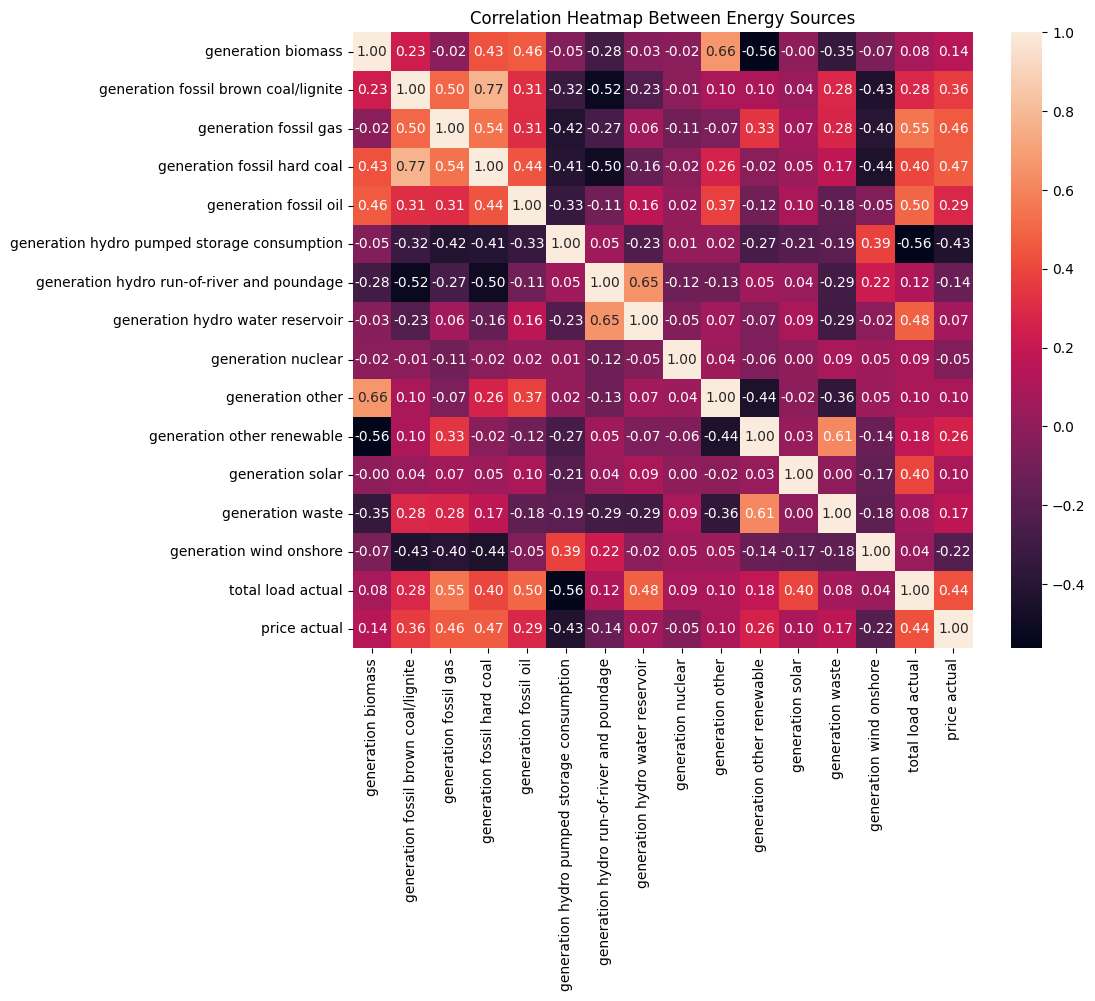

In [ ]:


# Calculate correlations
corr = energy_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title('Correlation Heatmap Between Energy Sources')
plt.show()


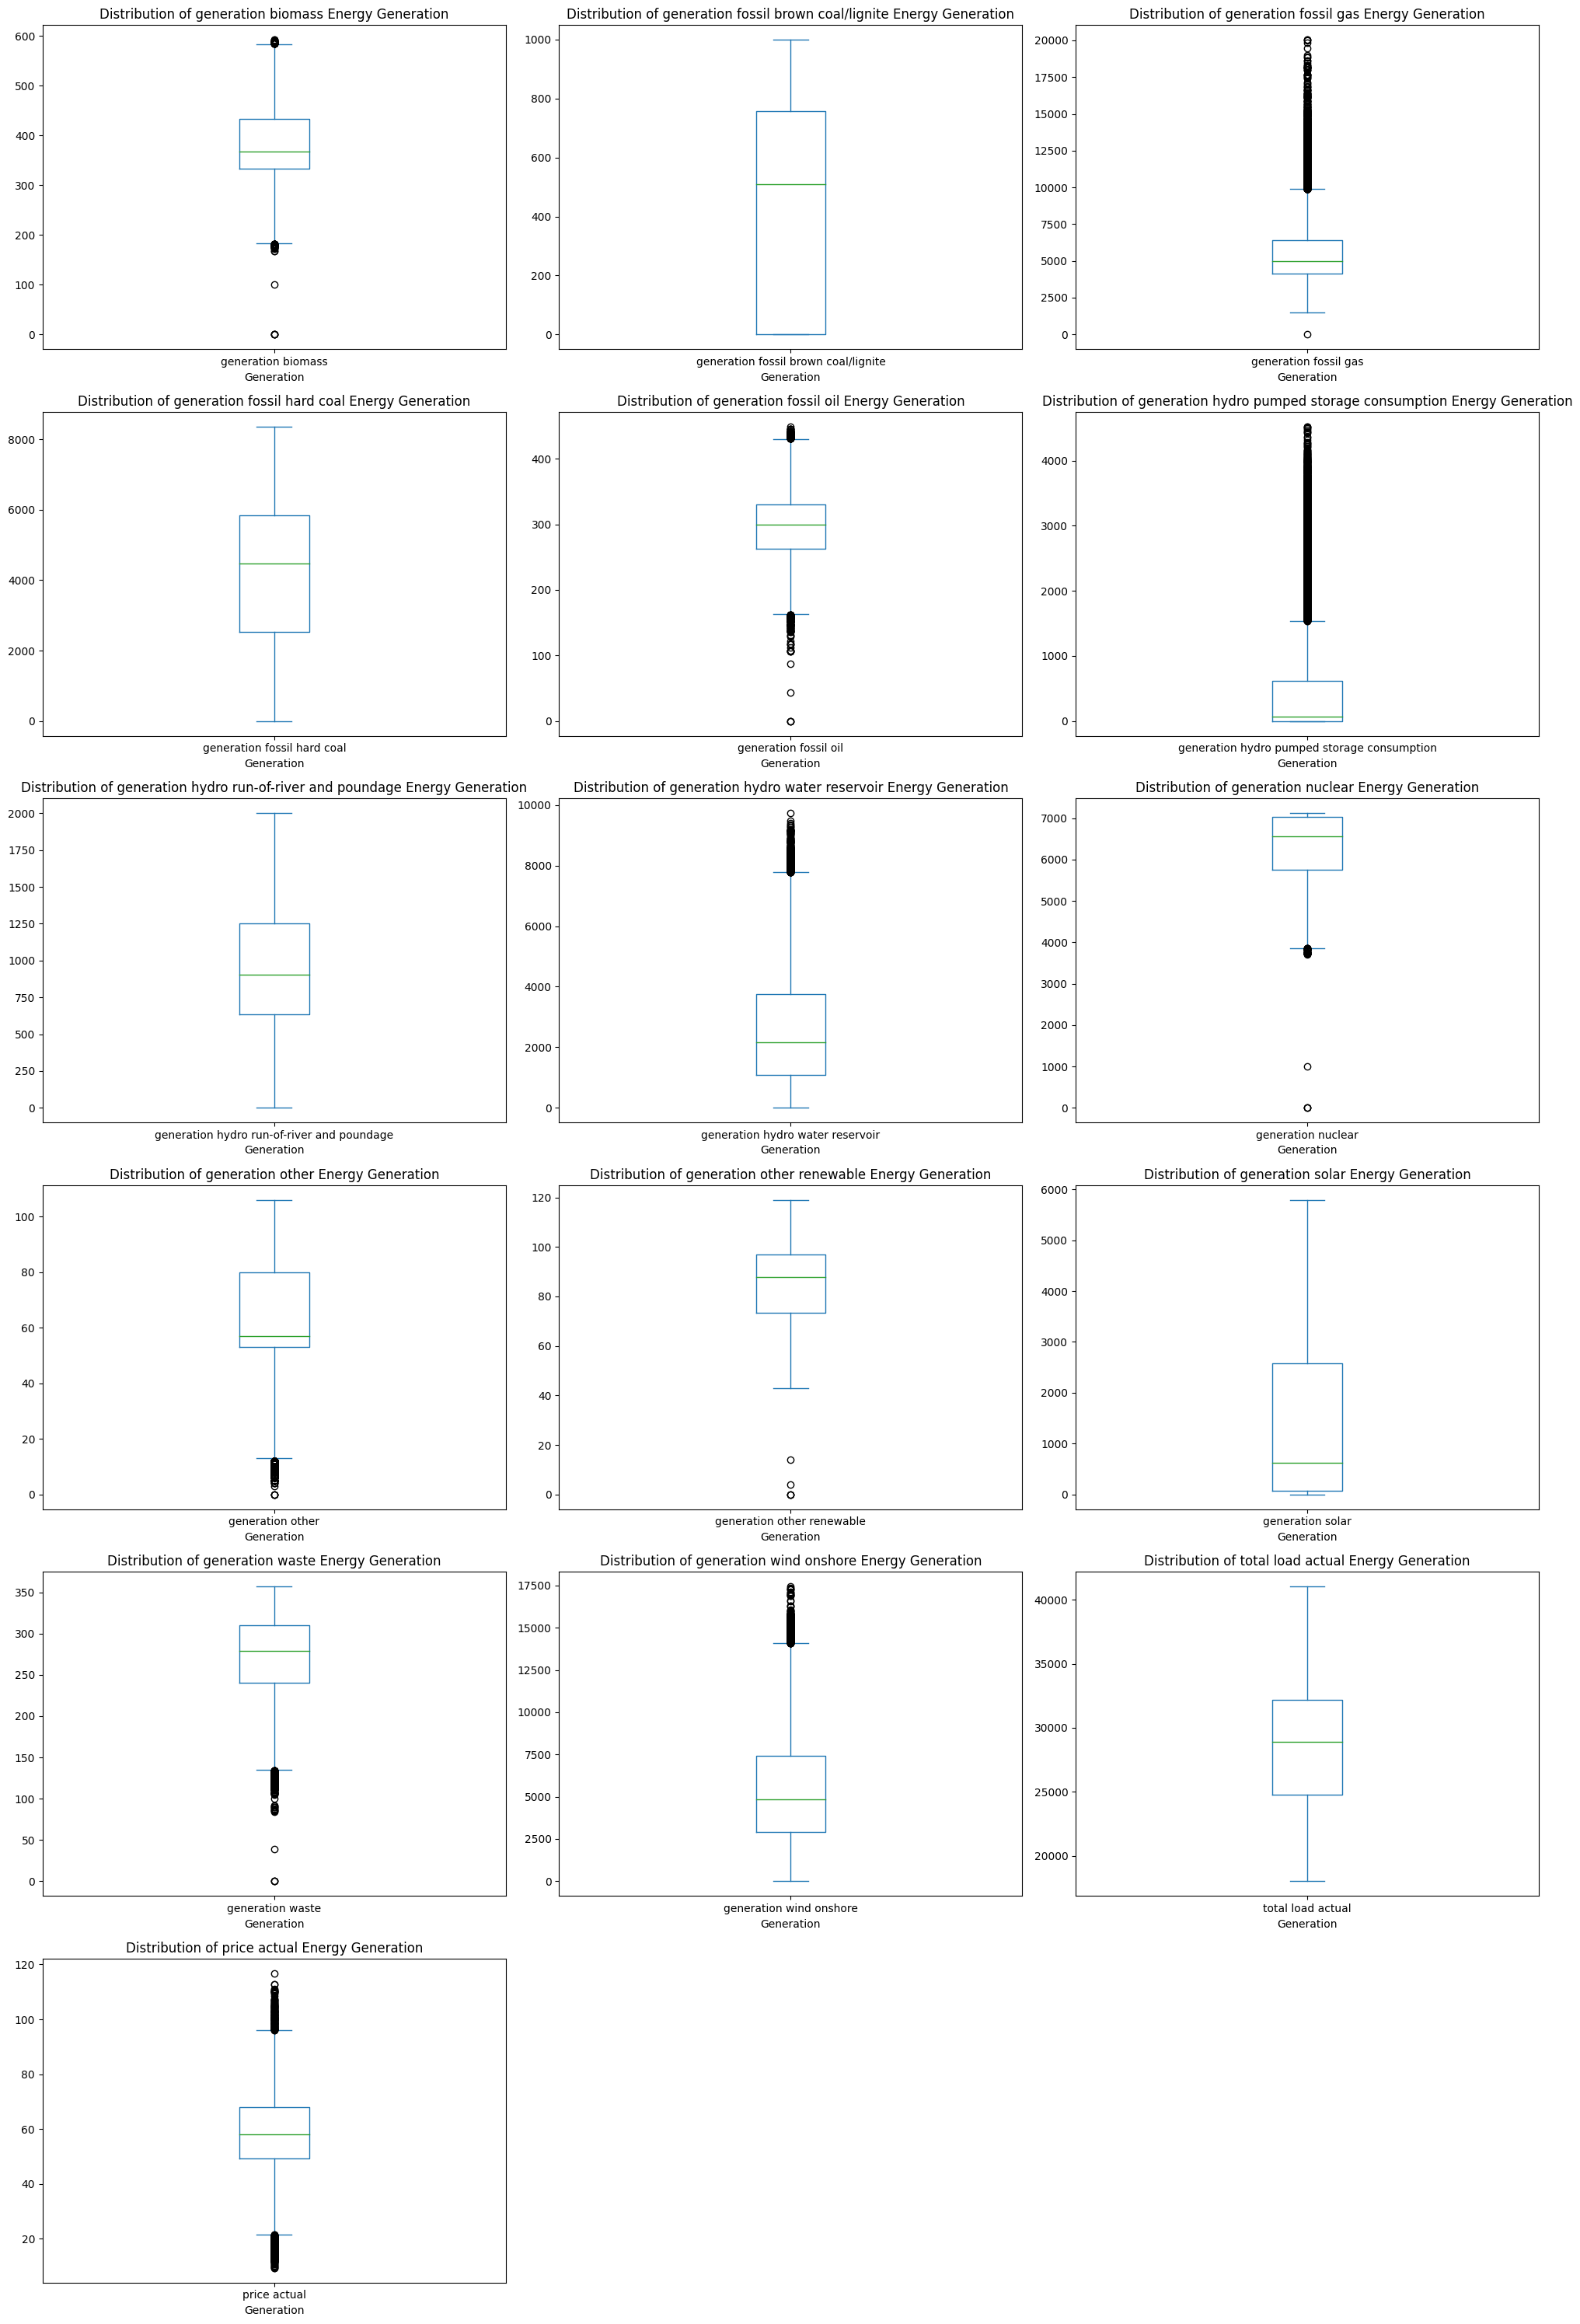

In [ ]:
import matplotlib.pyplot as plt

# Number of plots in each row
plots_per_row = 3

# Calculate the number of rows needed
num_columns = len(energy_df.columns)
num_rows = (num_columns + plots_per_row - 1) // plots_per_row

# Create a figure and set of subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(20, num_rows * 5))

# Flatten axes array if more than one row
axes = axes.flatten() if num_rows > 1 else [axes]

# Plot data
for idx, column in enumerate(energy_df.columns):
    energy_df[column].plot(kind='box', ax=axes[idx])
    axes[idx].set_title(f'Distribution of {column} Energy Generation')
    axes[idx].set_xlabel('Generation')


for idx in range(len(energy_df.columns), len(axes)):
    axes[idx].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


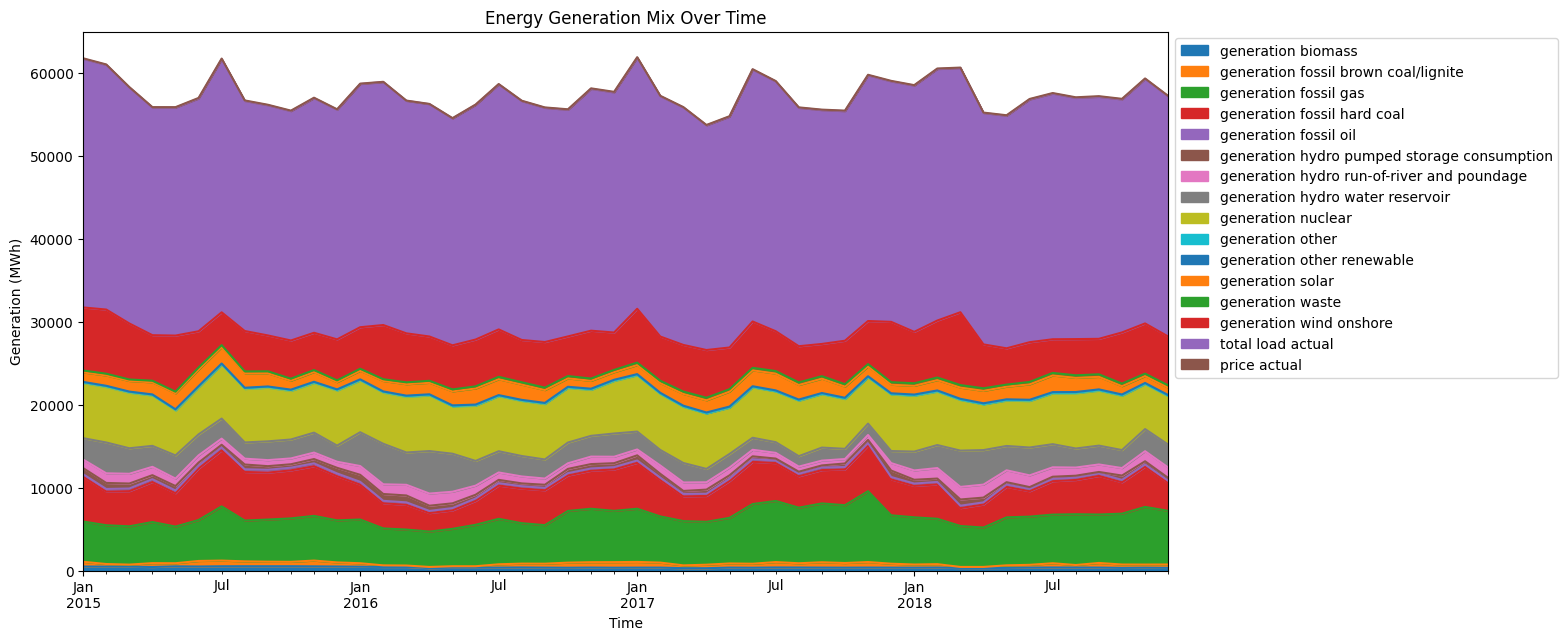

In [ ]:


energy_mix = energy_df[['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price actual']]
energy_mix_resampled = energy_mix.resample('M').mean()

# Plotting
energy_mix_resampled.plot(kind='area', stacked=True, figsize=(14, 7))
plt.title('Energy Generation Mix Over Time')
plt.ylabel('Generation (MWh)')
plt.xlabel('Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


In [ ]:
# Calculating the correlation matrix
correlation_matrix = energy_df.corr()

# Correlations with total load and price
corr_with_load = correlation_matrix['total load actual'].sort_values(ascending=False)
corr_with_price = correlation_matrix['price actual'].sort_values(ascending=False)

# Print top correlated sources with total load and price for inspection
print("Top correlated sources with total load:\n", corr_with_load.head(6))
print("\nTop correlated sources with price:\n", corr_with_price.head(6))

# Calculating the average generation for each source to find the highest generating sources
average_generation = energy_df.loc[:, 'generation biomass':'generation wind onshore'].mean().sort_values(ascending=False)

# Print top energy-generating sources for inspection
print("\nTop energy-generating sources:\n", average_generation.head())

Top correlated sources with total load:
 total load actual                   1.000000
generation fossil gas               0.548988
generation fossil oil               0.496170
generation hydro water reservoir    0.479249
price actual                        0.435589
generation fossil hard coal         0.396956
Name: total load actual, dtype: float64

Top correlated sources with price:
 price actual                            1.000000
generation fossil hard coal             0.465646
generation fossil gas                   0.461431
total load actual                       0.435589
generation fossil brown coal/lignite    0.363993
generation fossil oil                   0.285088
Name: price actual, dtype: float64

Top energy-generating sources:
 generation nuclear                  6263.478111
generation fossil gas               5622.727861
generation wind onshore             5465.089553
generation fossil hard coal         4256.534524
generation hydro water reservoir    2605.516271
dtype: flo

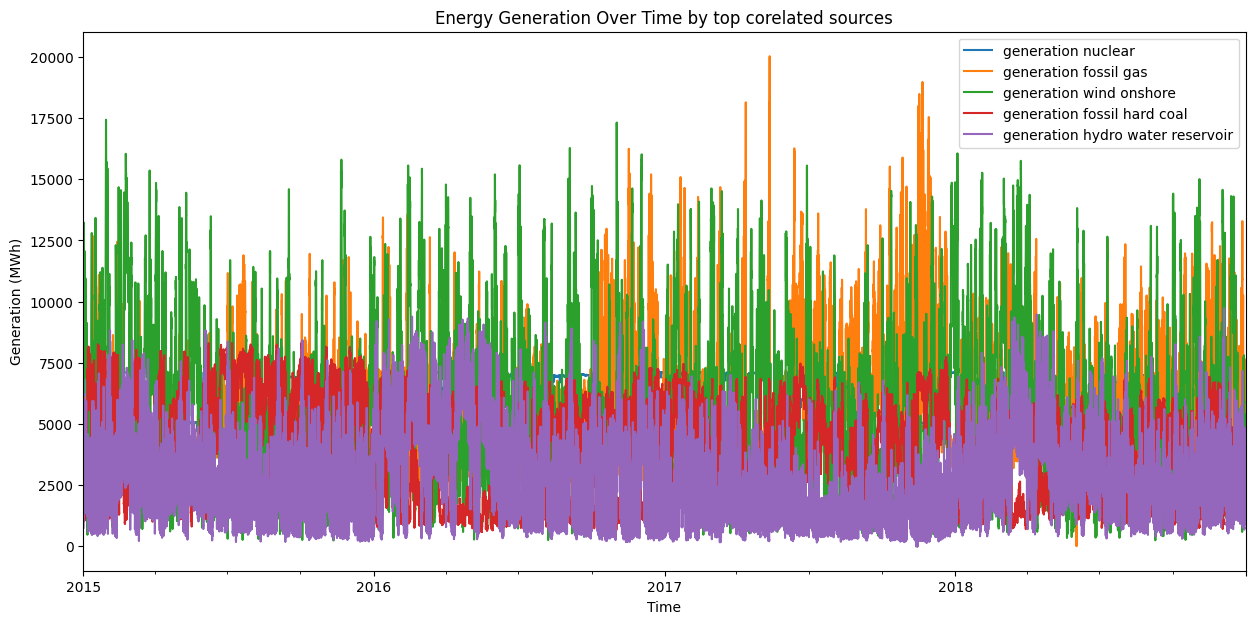

In [ ]:
#energy_sources = ["generation biomass", "generation fossil gas", "generation nuclear", "generation solar", "generation wind onshore"]
energy_sources = ["generation nuclear", "generation fossil gas", "generation wind onshore", "generation fossil hard coal",   "generation hydro water reservoir"]
energy_df[energy_sources].plot(figsize=(15, 7))
plt.title("Energy Generation Over Time by top corelated sources")
plt.ylabel("Generation (MWh)")
plt.xlabel("Time")
plt.legend()
plt.show()


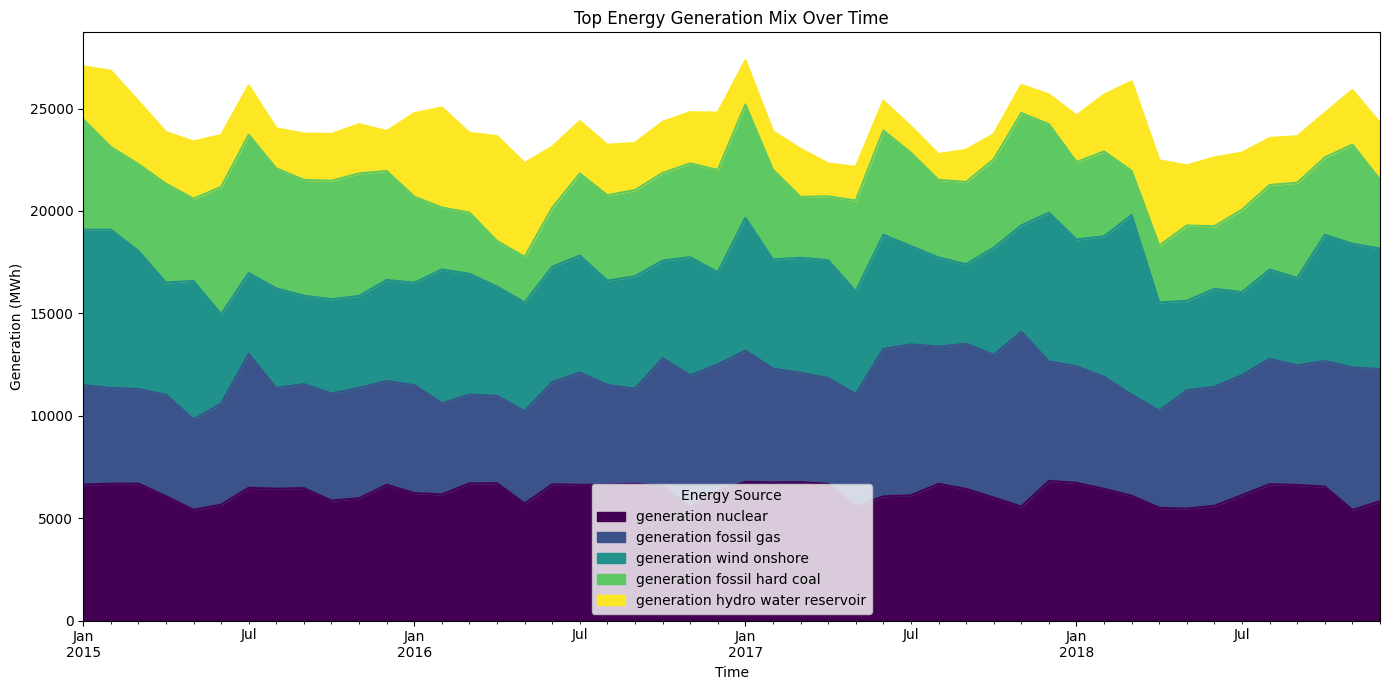

In [ ]:

top_sources_list = ["generation nuclear", "generation fossil gas", "generation wind onshore", "generation fossil hard coal",   "generation hydro water reservoir"]
# Filter the dataframe for these top sources
energy_top_sources = energy_df[top_sources_list]

# Resample to monthly data for smoother visualization
energy_top_sources_resampled = energy_top_sources.resample('M').mean()

# Plotting
energy_top_sources_resampled.plot(kind='area', stacked=True, figsize=(14, 7), colormap='viridis')
plt.title('Top Energy Generation Mix Over Time')
plt.ylabel('Generation (MWh)')
plt.xlabel('Time')
plt.legend(title='Energy Source')
plt.tight_layout()
plt.show()


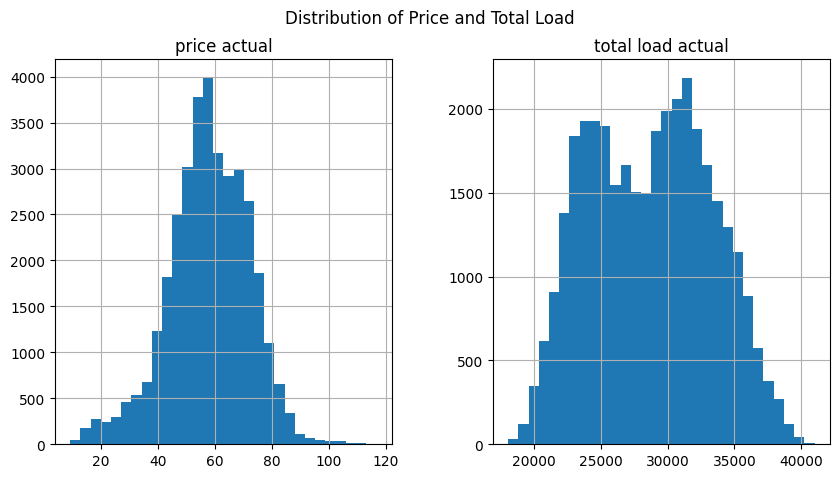

In [ ]:
energy_df[['price actual', 'total load actual']].hist(bins=30, figsize=(10, 5))
plt.suptitle("Distribution of Price and Total Load")
plt.show()


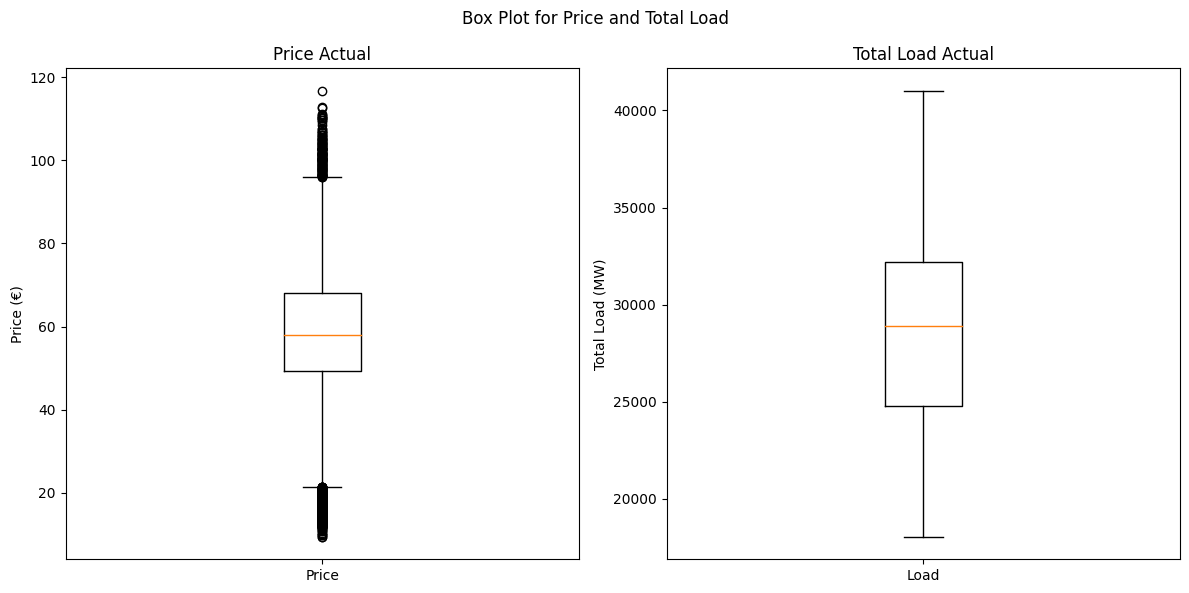

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Box plot for 'price actual' on the first subplot
ax1.boxplot(energy_df['price actual'])
ax1.set_title('Price Actual')
ax1.set_ylabel('Price (€)')
ax1.set_xticklabels(['Price'])

# Box plot for 'total load actual' on the second subplot
ax2.boxplot(energy_df['total load actual'])
ax2.set_title('Total Load Actual')
ax2.set_ylabel('Total Load (MW)')
ax2.set_xticklabels(['Load'])

# Overall figure title
plt.suptitle('Box Plot for Price and Total Load')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Check for any negative values in specified columns
negative_price = (energy_df['price actual'] < 0).any()
negative_load = (energy_df['total load actual'] < 0).any()

# Print results
print(f"Negative values in 'price actual': {'Yes' if negative_price else 'No'}")
print(f"Negative values in 'total load actual': {'Yes' if negative_load else 'No'}")


Negative values in 'price actual': No
Negative values in 'total load actual': No























# Weather Dataset

In [ ]:
weather_df.head()

city_name     temp  temp_min  temp_max  pressure  \
dt_iso                                                                       
2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

                           humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
dt_iso                                                                        
2015-01-01 00:00:00+01:00        77           1        62      0.0      0.0   
2015-01-01 01:00:00+01:00        77           1        62      0.0      0.0   
2015-01-01 02:00:00+01:00        78           0        23      0.0      0.0   
2015-01-01 03:00:00+01:00        78           0        23      0.0      0.0   
2015-01-01 04:00:00+01:00        78           0        23      0.0      0.0   

                           snow_3h  clouds_all  weather_id weather_main  \
dt_iso                                                                    
2015-01-01 00:00:00+01:00      0.0           0         800        clear   
2015-01-01 01:00:00+01:00      0.0           0         800        clear   
2015-01-01 02:00:00+01:00      0.0           0         800        clear   
2015-01-01 03:00:00+01:00      0.0           0         800        clear   
2015-01-01 04:00:00+01:00      0.0           0         800        clear   

                          weather_description weather_icon  
dt_iso                                                      
2015-01-01 00:00:00+01:00        sky is clear          01n  
2015-01-01 01:00:00+01:00        sky is clear          01n  
2015-01-01 02:00:00+01:00        sky is clear          01n  
2015-01-01 03:00:00+01:00        sky is clear          01n  
2015-01-01 04:00:00+01:00        sky is clear          01n

In [ ]:
#converting the date of weather dataframe into utc timezone, same as energy dataframe
weather_df.index = pd.to_datetime(weather_df.index, utc=True).tz_localize(None)
weather_df.head()

city_name     temp  temp_min  temp_max  pressure  \
dt_iso                                                                 
2014-12-31 23:00:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 00:00:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 01:00:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 02:00:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 03:00:00  Valencia  269.686   269.686   269.686      1002   

                     humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
dt_iso                                                                  
2014-12-31 23:00:00        77           1        62      0.0      0.0   
2015-01-01 00:00:00        77           1        62      0.0      0.0   
2015-01-01 01:00:00        78           0        23      0.0      0.0   
2015-01-01 02:00:00        78           0        23      0.0      0.0   
2015-01-01 03:00:00        78           0        23      0.0      0.0   

                     snow_3h  clouds_all  weather_id weather_main  \
dt_iso                                                              
2014-12-31 23:00:00      0.0           0         800        clear   
2015-01-01 00:00:00      0.0           0         800        clear   
2015-01-01 01:00:00      0.0           0         800        clear   
2015-01-01 02:00:00      0.0           0         800        clear   
2015-01-01 03:00:00      0.0           0         800        clear   

                    weather_description weather_icon  
dt_iso                                                
2014-12-31 23:00:00        sky is clear          01n  
2015-01-01 00:00:00        sky is clear          01n  
2015-01-01 01:00:00        sky is clear          01n  
2015-01-01 02:00:00        sky is clear          01n  
2015-01-01 03:00:00        sky is clear          01n

In [ ]:

weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178396 entries, 2014-12-31 23:00:00 to 2018-12-31 22:00:00
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   city_name            178396 non-null  object 
 1   temp                 178396 non-null  float64
 2   temp_min             178396 non-null  float64
 3   temp_max             178396 non-null  float64
 4   pressure             178396 non-null  int64  
 5   humidity             178396 non-null  int64  
 6   wind_speed           178396 non-null  int64  
 7   wind_deg             178396 non-null  int64  
 8   rain_1h              178396 non-null  float64
 9   rain_3h              178396 non-null  float64
 10  snow_3h              178396 non-null  float64
 11  clouds_all           178396 non-null  int64  
 12  weather_id           178396 non-null  int64  
 13  weather_main         178396 non-null  object 
 14  weather_description  178396 non-nu

In [ ]:
weather_df.isnull().sum()

city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

In [ ]:
#dropping weather_icon column from weather dataset
weather_df.drop(columns=['weather_icon','weather_main', 'weather_description','weather_id'], inplace=True)

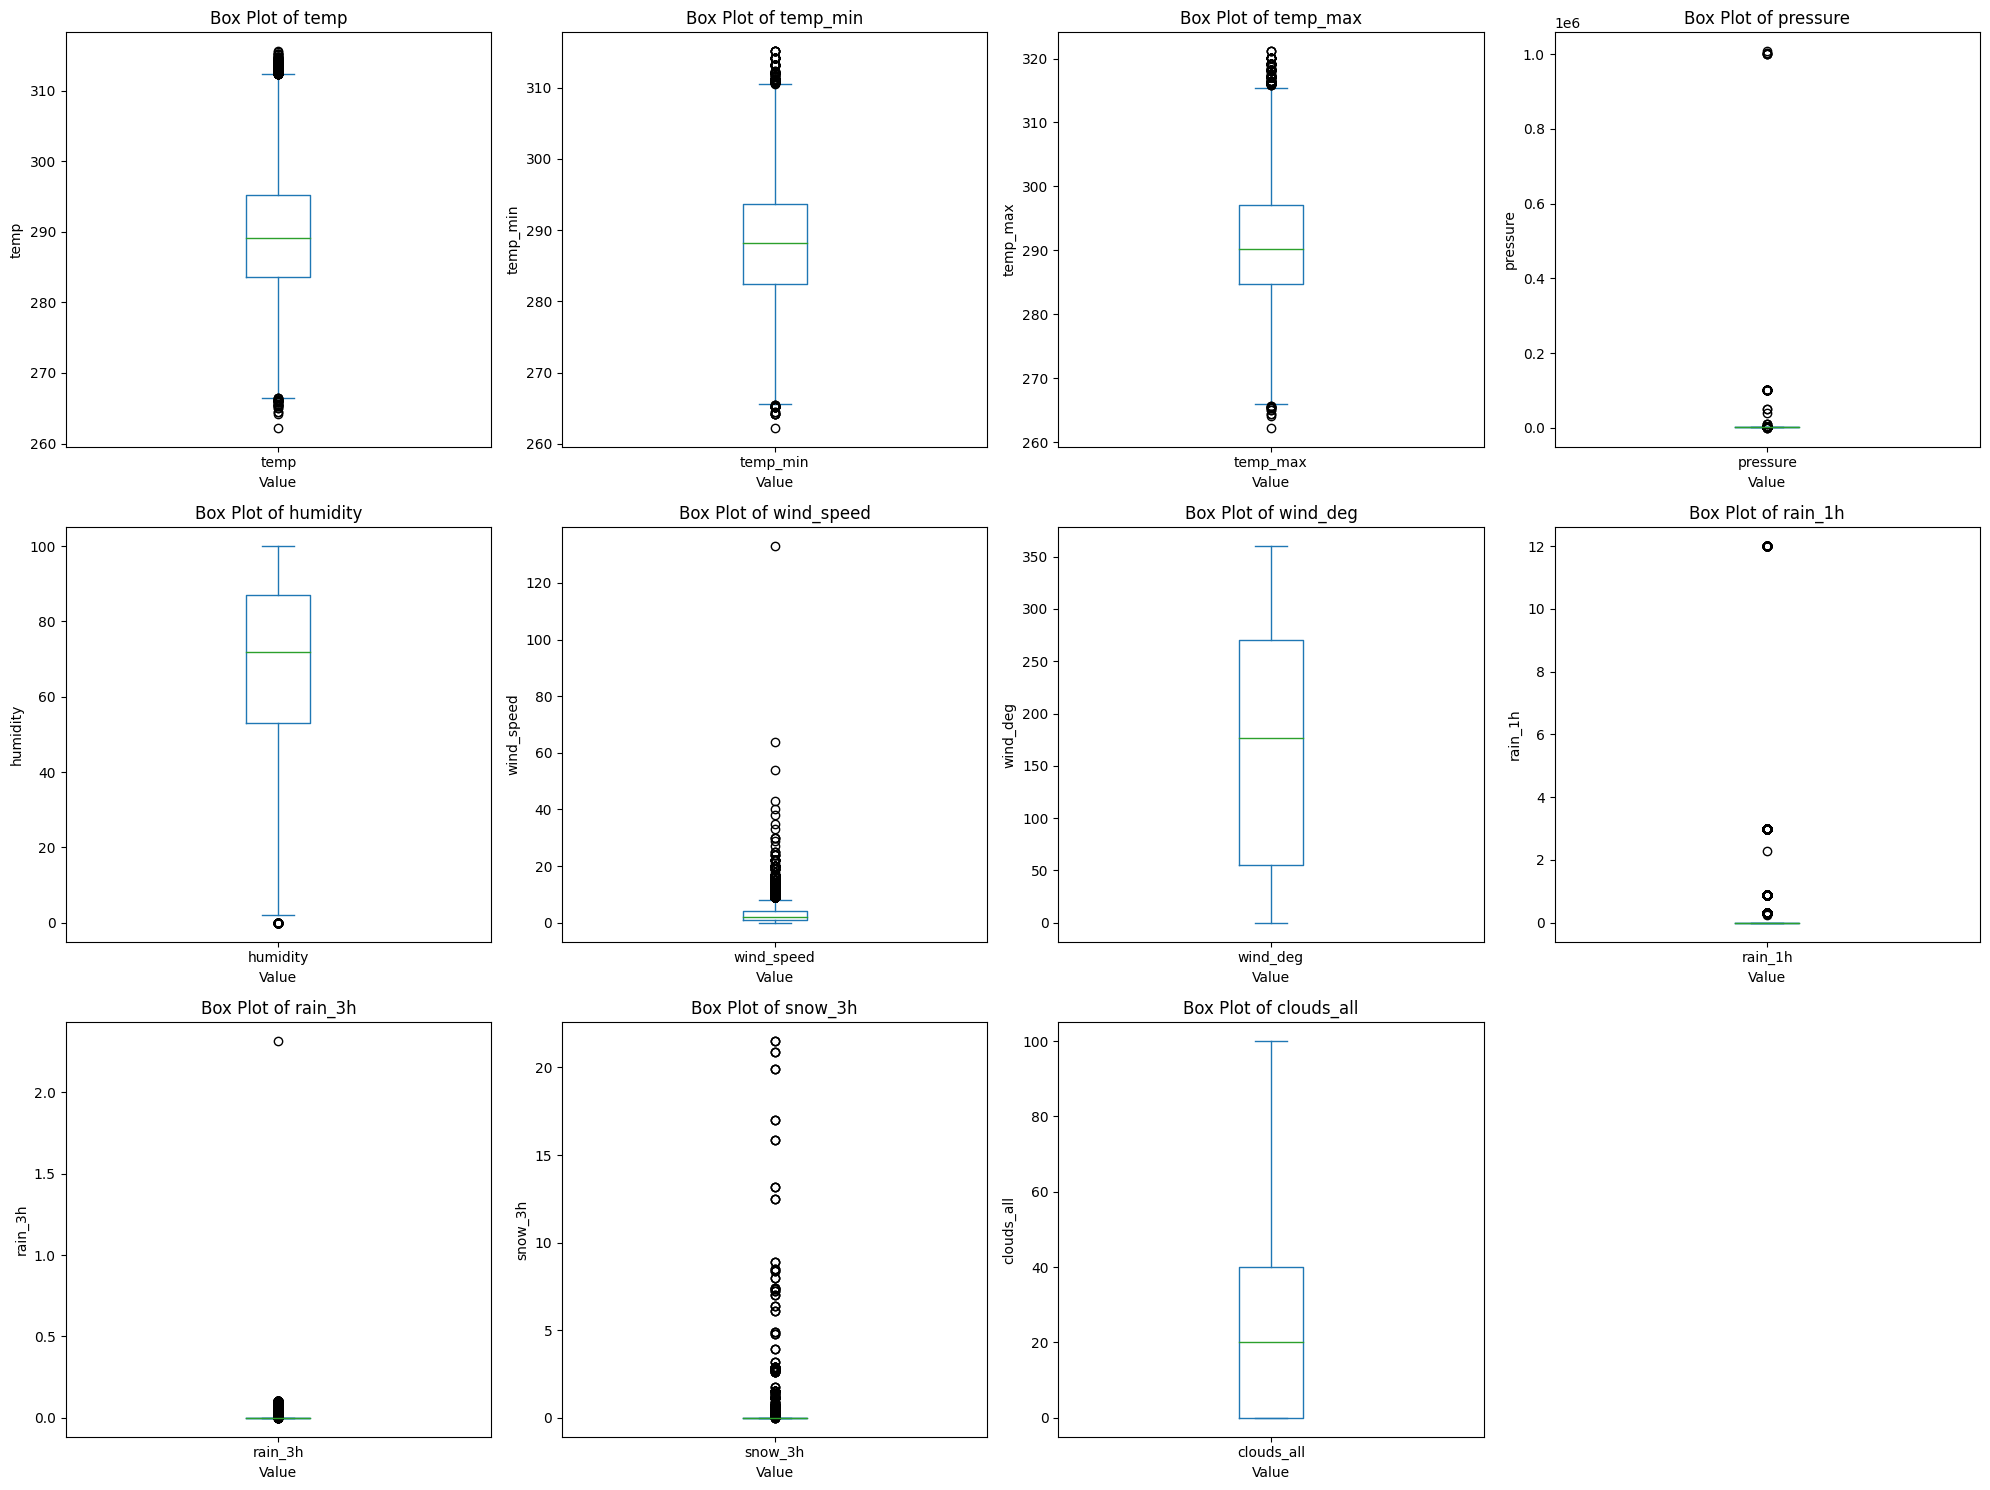

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd

# Filter out non-numeric columns
numeric_cols = weather_df.select_dtypes(include=[np.number]).columns

# Define the number of plots per row
plots_per_row = 4

# Get the total number of numeric columns
num_columns = len(numeric_cols)

# Calculate the number of rows needed based on the number of numeric columns
num_rows = (num_columns + plots_per_row - 1) // plots_per_row  # Rounds up if not an even multiple

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(20, 5 * num_rows))

# Flatten axes array to simplify the indexing in the loop (works for both single and multiple rows)
axes = axes.flatten()

# Loop through each numeric column in the DataFrame
for idx, column in enumerate(numeric_cols):
    # Plot the box plot for each numeric column
    weather_df[column].plot(kind='box', ax=axes[idx])
    axes[idx].set_title(f'Box Plot of {column}')
    axes[idx].set_ylabel(column)
    axes[idx].set_xlabel('Value')

# Turn off any unused axes
for idx in range(num_columns, len(axes)):
    axes[idx].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


from the above plot we can see that there are few outliers in rain_3h,rain_1h, pressure and wind speed
we will try to remove to increase the efficiency of the model



In [ ]:
#applying  constraints to windspeed column
weather_df['wind_speed'] = weather_df['wind_speed'].apply(lambda x: 60 if x > 60 else (0 if x < 0 else x))

In [ ]:
#applying constraints to rain_3h column
weather_df['rain_3h'] = weather_df['rain_3h'].apply(lambda x: 0.3 if x > 0.3 else (0 if x < 0 else x))

In [ ]:
#applying constraints to rain column
weather_df['rain_1h'] = weather_df['rain_1h'].apply(lambda x: 4 if x > 4  else x)

In [ ]:


#applying constraints to snow column
weather_df['snow_3h'] = weather_df['snow_3h'].apply(lambda x: 10 if x > 10 else x)

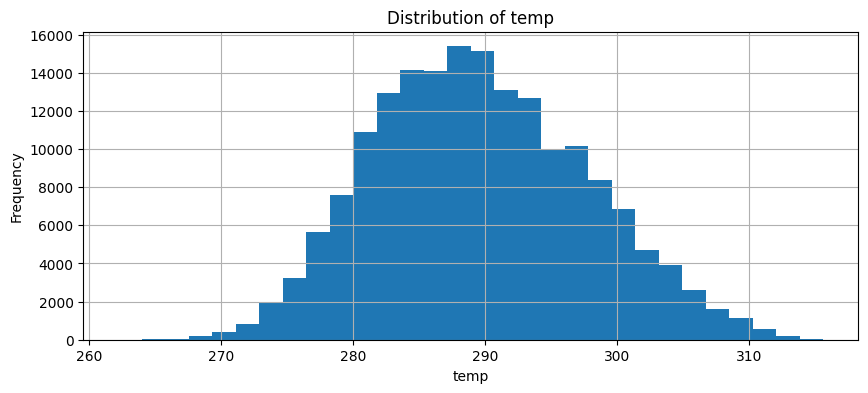

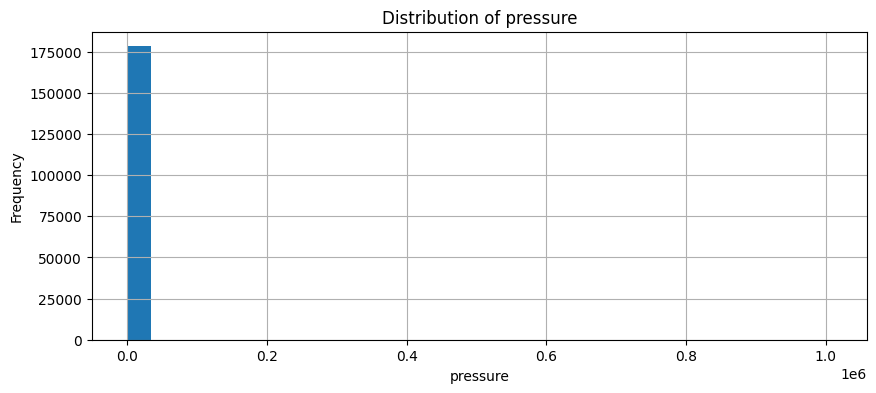

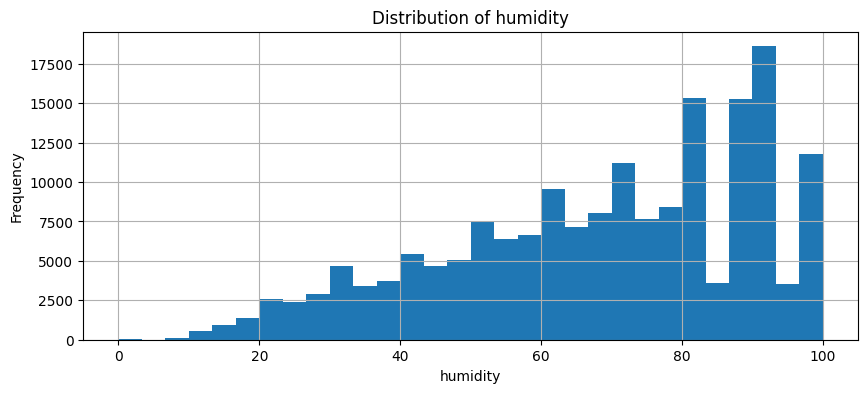

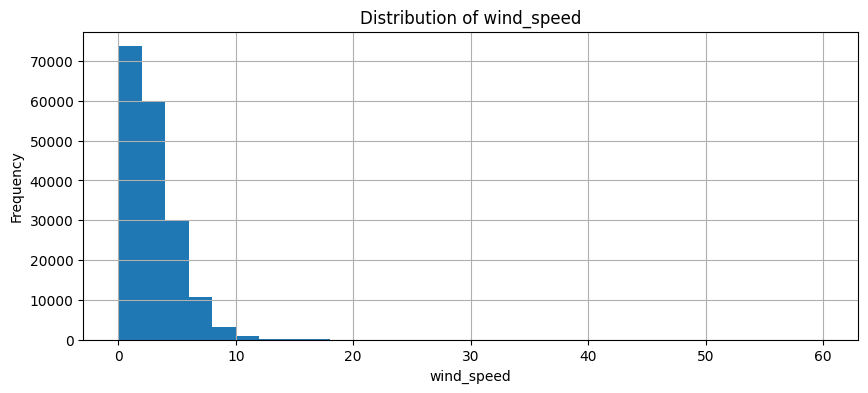

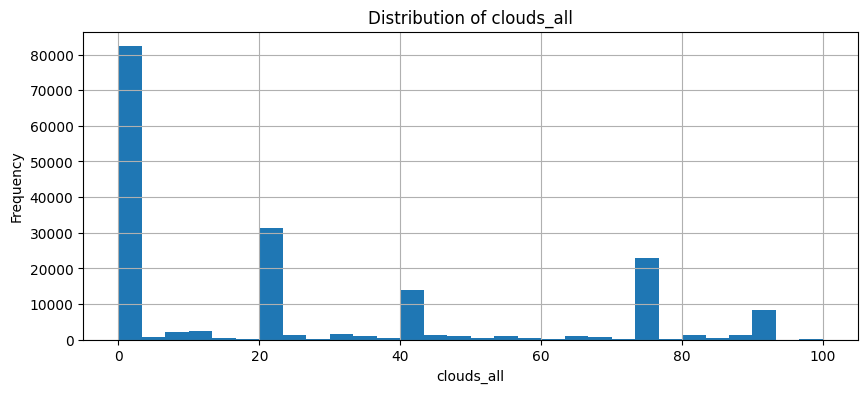

In [ ]:
weather_conditions = ['temp', 'pressure', 'humidity', 'wind_speed', 'clouds_all']

for condition in weather_conditions:
    plt.figure(figsize=(10, 4))
    weather_df[condition].hist(bins=30)
    plt.title(f'Distribution of {condition}')
    plt.xlabel(condition)
    plt.ylabel('Frequency')
    plt.show()


In [ ]:
weather_df['city_name'].value_counts()

city_name
Madrid        36267
Bilbao        35951
Seville       35557
 Barcelona    35476
Valencia      35145
Name: count, dtype: int64

In [ ]:
# filtering and creating new dataframes as per city

madird_df = weather_df[weather_df['city_name'] == 'Madrid']
bilbao_df = weather_df[weather_df['city_name'] == 'Bilbao']
seville_df = weather_df[weather_df['city_name'] == 'Seville']
barcelona_df = weather_df[weather_df['city_name'] == ' Barcelona']
valencia_df = weather_df[weather_df['city_name'] == 'Valencia']
valencia_df.tail()

city_name    temp  temp_min  temp_max  pressure  humidity  \
dt_iso                                                                          
2018-12-31 18:00:00  Valencia  285.64    285.15    286.15      1028        62   
2018-12-31 19:00:00  Valencia  283.14    282.15    284.15      1029        71   
2018-12-31 20:00:00  Valencia  281.66    281.15    282.15      1029        81   
2018-12-31 21:00:00  Valencia  280.14    279.15    281.15      1029        81   
2018-12-31 22:00:00  Valencia  279.14    278.15    280.15      1029        75   

                     wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  \
dt_iso                                                                 
2018-12-31 18:00:00           2       140      0.0      0.0      0.0   
2018-12-31 19:00:00           1       242      0.0      0.0      0.0   
2018-12-31 20:00:00           3       300      0.0      0.0      0.0   
2018-12-31 21:00:00           2       310      0.0      0.0      0.0   
2018-12-31 22:00:00           2       300      0.0      0.0      0.0   

                     clouds_all  
dt_iso                           
2018-12-31 18:00:00           0  
2018-12-31 19:00:00           0  
2018-12-31 20:00:00           0  
2018-12-31 21:00:00           0  
2018-12-31 22:00:00           0

In [ ]:
# Renaming columns with the city name prefix
# dropping city_name column as if is no longer needed

new_column_madrid = ['madrid' + '_' + column for column in madird_df.columns]
madird_df.columns = new_column_madrid
madird_df.rename(columns={'madrid_dt_iso': '_dt_iso'}, inplace=True)
madird_df.drop(columns=['madrid_city_name'], inplace=True)



new_column_bilbao = ['bilbao' + '_' + column for column in bilbao_df.columns]
bilbao_df.columns = new_column_bilbao
bilbao_df.rename(columns={'bilbao_dt_iso': '_dt_iso'}, inplace=True)
bilbao_df.drop(columns=['bilbao_city_name'], inplace=True)



new_column_seville = ['seville' + '_' + column for column in seville_df.columns]
seville_df.columns = new_column_seville
seville_df.rename(columns={'seville_dt_iso': '_dt_iso'}, inplace=True)
seville_df.drop(columns=['seville_city_name'], inplace=True)



new_column_barcelona = ['barcelona' + '_' + column for column in barcelona_df.columns]
barcelona_df.columns = new_column_barcelona
barcelona_df.rename(columns={'barcelona_dt_iso': '_dt_iso'}, inplace=True)
barcelona_df.drop(columns=['barcelona_city_name'], inplace=True)



new_column_valencia = ['valencia' + '_' + column for column in valencia_df.columns]
valencia_df.columns = new_column_valencia
valencia_df.rename(columns={'valencia_dt_iso': '_dt_iso'}, inplace=True)
valencia_df.drop(columns=['valencia_city_name'], inplace=True)



valencia_df.head()

<ipython-input-52-7b9b9d55edae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  madird_df.rename(columns={'madrid_dt_iso': '_dt_iso'}, inplace=True)
<ipython-input-52-7b9b9d55edae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  madird_df.drop(columns=['madrid_city_name'], inplace=True)
<ipython-input-52-7b9b9d55edae>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bilbao_df.rename(columns={'bilbao_dt_iso': '_dt_iso'}, inplace=True

valencia_temp  valencia_temp_min  valencia_temp_max  \
dt_iso                                                                     
2014-12-31 23:00:00        270.475            270.475            270.475   
2015-01-01 00:00:00        270.475            270.475            270.475   
2015-01-01 01:00:00        269.686            269.686            269.686   
2015-01-01 02:00:00        269.686            269.686            269.686   
2015-01-01 03:00:00        269.686            269.686            269.686   

                     valencia_pressure  valencia_humidity  \
dt_iso                                                      
2014-12-31 23:00:00               1001                 77   
2015-01-01 00:00:00               1001                 77   
2015-01-01 01:00:00               1002                 78   
2015-01-01 02:00:00               1002                 78   
2015-01-01 03:00:00               1002                 78   

                     valencia_wind_speed  valencia_wind_deg  valencia_rain_1h  \
dt_iso                                                                          
2014-12-31 23:00:00                    1                 62               0.0   
2015-01-01 00:00:00                    1                 62               0.0   
2015-01-01 01:00:00                    0                 23               0.0   
2015-01-01 02:00:00                    0                 23               0.0   
2015-01-01 03:00:00                    0                 23               0.0   

                     valencia_rain_3h  valencia_snow_3h  valencia_clouds_all  
dt_iso                                                                        
2014-12-31 23:00:00               0.0               0.0                    0  
2015-01-01 00:00:00               0.0               0.0                    0  
2015-01-01 01:00:00               0.0               0.0                    0  
2015-01-01 02:00:00               0.0               0.0                    0  
2015-01-01 03:00:00               0.0               0.0                    0

In [ ]:

# printing the shapes of all city dataframes in order to see whether all the shapes match for proper merging
print(f'Shape of all the city data is {madird_df.shape}, {bilbao_df.shape}, {seville_df.shape}, {barcelona_df.shape}, {valencia_df.shape}')


Shape of all the city data is (36267, 11), (35951, 11), (35557, 11), (35476, 11), (35145, 11)


In [ ]:

# merging all the city dataframes into single weather dataframes
merged_df = pd.merge(madird_df, bilbao_df, left_index=True, right_index=True, how='inner')
merged_df1 = pd.merge(merged_df, seville_df, left_index=True, right_index=True, how='inner')
merged_df2 = pd.merge(merged_df1, barcelona_df, left_index=True, right_index=True, how='inner')
merged_df3 = pd.merge(merged_df2, valencia_df, left_index=True, right_index=True, how='inner')

In [ ]:
merged_df3.head()

madrid_temp  madrid_temp_min  madrid_temp_max  \
dt_iso                                                               
2014-12-31 23:00:00      267.325          267.325          267.325   
2015-01-01 00:00:00      267.325          267.325          267.325   
2015-01-01 01:00:00      266.186          266.186          266.186   
2015-01-01 02:00:00      266.186          266.186          266.186   
2015-01-01 03:00:00      266.186          266.186          266.186   

                     madrid_pressure  madrid_humidity  madrid_wind_speed  \
dt_iso                                                                     
2014-12-31 23:00:00              971               63                  1   
2015-01-01 00:00:00              971               63                  1   
2015-01-01 01:00:00              971               64                  1   
2015-01-01 02:00:00              971               64                  1   
2015-01-01 03:00:00              971               64                  1   

                     madrid_wind_deg  madrid_rain_1h  madrid_rain_3h  \
dt_iso                                                                 
2014-12-31 23:00:00              309             0.0             0.0   
2015-01-01 00:00:00              309             0.0             0.0   
2015-01-01 01:00:00              273             0.0             0.0   
2015-01-01 02:00:00              273             0.0             0.0   
2015-01-01 03:00:00              273             0.0             0.0   

                     madrid_snow_3h  madrid_clouds_all  bilbao_temp  \
dt_iso                                                                
2014-12-31 23:00:00             0.0                  0   269.657312   
2015-01-01 00:00:00             0.0                  0   269.763500   
2015-01-01 01:00:00             0.0                  0   269.251688   
2015-01-01 02:00:00             0.0                  0   269.203344   
2015-01-01 03:00:00             0.0                  0   269.485500   

                     bilbao_temp_min  bilbao_temp_max  bilbao_pressure  \
dt_iso                                                                   
2014-12-31 23:00:00       269.657312       269.657312             1036   
2015-01-01 00:00:00       269.763500       269.763500             1035   
2015-01-01 01:00:00       269.251688       269.251688             1036   
2015-01-01 02:00:00       269.203344       269.203344             1035   
2015-01-01 03:00:00       269.485500       269.485500             1035   

                     bilbao_humidity  bilbao_wind_speed  bilbao_wind_deg  \
dt_iso                                                                     
2014-12-31 23:00:00               97                  0              226   
2015-01-01 00:00:00               97                  0              229   
2015-01-01 01:00:00               97                  1              224   
2015-01-01 02:00:00               97                  1              225   
2015-01-01 03:00:00               97                  1              221   

                     bilbao_rain_1h  bilbao_rain_3h  bilbao_snow_3h  \
dt_iso                                                                
2014-12-31 23:00:00             0.0             0.0             0.0   
2015-01-01 00:00:00             0.0             0.0             0.0   
2015-01-01 01:00:00             0.0             0.0             0.0   
2015-01-01 02:00:00             0.0             0.0             0.0   
2015-01-01 03:00:00             0.0             0.0             0.0   

                     bilbao_clouds_all  seville_temp  seville_temp_min  \
dt_iso                                                                   
2014-12-31 23:00:00                  0       273.375           273.375   
2015-01-01 00:00:00                  0       273.375           273.375   
2015-01-01 01:00:00                  0       274.086           274.086   
2015-01-01 02:00:00                  0       274.086           274.086   


In [ ]:
#naming the merged weather city dataframes as weather_df_merged
weather_df_merged=merged_df3

In [ ]:

#final dataframe from weather sheet after all modifications
weather_df_merged.head()

madrid_temp  madrid_temp_min  madrid_temp_max  \
dt_iso                                                               
2014-12-31 23:00:00      267.325          267.325          267.325   
2015-01-01 00:00:00      267.325          267.325          267.325   
2015-01-01 01:00:00      266.186          266.186          266.186   
2015-01-01 02:00:00      266.186          266.186          266.186   
2015-01-01 03:00:00      266.186          266.186          266.186   

                     madrid_pressure  madrid_humidity  madrid_wind_speed  \
dt_iso                                                                     
2014-12-31 23:00:00              971               63                  1   
2015-01-01 00:00:00              971               63                  1   
2015-01-01 01:00:00              971               64                  1   
2015-01-01 02:00:00              971               64                  1   
2015-01-01 03:00:00              971               64                  1   

                     madrid_wind_deg  madrid_rain_1h  madrid_rain_3h  \
dt_iso                                                                 
2014-12-31 23:00:00              309             0.0             0.0   
2015-01-01 00:00:00              309             0.0             0.0   
2015-01-01 01:00:00              273             0.0             0.0   
2015-01-01 02:00:00              273             0.0             0.0   
2015-01-01 03:00:00              273             0.0             0.0   

                     madrid_snow_3h  madrid_clouds_all  bilbao_temp  \
dt_iso                                                                
2014-12-31 23:00:00             0.0                  0   269.657312   
2015-01-01 00:00:00             0.0                  0   269.763500   
2015-01-01 01:00:00             0.0                  0   269.251688   
2015-01-01 02:00:00             0.0                  0   269.203344   
2015-01-01 03:00:00             0.0                  0   269.485500   

                     bilbao_temp_min  bilbao_temp_max  bilbao_pressure  \
dt_iso                                                                   
2014-12-31 23:00:00       269.657312       269.657312             1036   
2015-01-01 00:00:00       269.763500       269.763500             1035   
2015-01-01 01:00:00       269.251688       269.251688             1036   
2015-01-01 02:00:00       269.203344       269.203344             1035   
2015-01-01 03:00:00       269.485500       269.485500             1035   

                     bilbao_humidity  bilbao_wind_speed  bilbao_wind_deg  \
dt_iso                                                                     
2014-12-31 23:00:00               97                  0              226   
2015-01-01 00:00:00               97                  0              229   
2015-01-01 01:00:00               97                  1              224   
2015-01-01 02:00:00               97                  1              225   
2015-01-01 03:00:00               97                  1              221   

                     bilbao_rain_1h  bilbao_rain_3h  bilbao_snow_3h  \
dt_iso                                                                
2014-12-31 23:00:00             0.0             0.0             0.0   
2015-01-01 00:00:00             0.0             0.0             0.0   
2015-01-01 01:00:00             0.0             0.0             0.0   
2015-01-01 02:00:00             0.0             0.0             0.0   
2015-01-01 03:00:00             0.0             0.0             0.0   

                     bilbao_clouds_all  seville_temp  seville_temp_min  \
dt_iso                                                                   
2014-12-31 23:00:00                  0       273.375           273.375   
2015-01-01 00:00:00                  0       273.375           273.375   
2015-01-01 01:00:00                  0       274.086           274.086   
2015-01-01 02:00:00                  0       274.086           274.086   


In [ ]:
weather_df_merged.describe()

madrid_temp  madrid_temp_min  madrid_temp_max  madrid_pressure  \
count  38568.000000     38568.000000     38568.000000     38568.000000   
mean     287.847982       286.605950       288.946696      1012.080248   
std        9.240412         9.107617         9.586704        19.520540   
min      264.132000       264.132000       264.132000       927.000000   
25%      280.930000       279.820000       281.703000      1012.000000   
50%      286.340000       285.150000       287.150000      1017.000000   
75%      294.360000       293.150000       295.950000      1022.000000   
max      313.330000       312.150000       316.480000      1042.000000   

       madrid_humidity  madrid_wind_speed  madrid_wind_deg  madrid_rain_1h  \
count     38568.000000       38568.000000     38568.000000    38568.000000   
mean         60.568217           2.443969       173.352468        0.058689   
std          25.247863           1.985642       122.198354        0.229127   
min           0.000000           0.000000         0.000000        0.000000   
25%          39.000000           1.000000        50.000000        0.000000   
50%          62.000000           2.000000       187.000000        0.000000   
75%          82.000000           3.000000       270.000000        0.000000   
max         100.000000          18.000000       360.000000        3.000000   

       madrid_rain_3h  madrid_snow_3h  madrid_clouds_all   bilbao_temp  \
count    38568.000000    38568.000000       38568.000000  38568.000000   
mean         0.000121        0.000027          23.165007    286.212638   
std          0.002470        0.005341          31.261573      6.748787   
min          0.000000        0.000000           0.000000    266.850000   
25%          0.000000        0.000000           0.000000    281.300000   
50%          0.000000        0.000000           0.000000    285.940000   
75%          0.000000        0.000000          40.000000    290.760000   
max          0.100000        1.049000         100.000000    312.470000   

       bilbao_temp_min  bilbao_temp_max  bilbao_pressure  bilbao_humidity  \
count     38568.000000     38568.000000     38568.000000     38568.000000   
mean        284.719394       287.912341      1017.260838        78.993388   
std           6.792859         6.902992         9.842230        16.735348   
min         264.150000       268.978000       961.000000        11.000000   
25%         280.120492       283.150000      1013.000000        67.000000   
50%         284.150000       287.649000      1019.000000        82.000000   
75%         289.150000       292.150000      1023.000000        93.000000   
max         312.040000       318.710000      1042.000000       100.000000   

       bilbao_wind_speed  bilbao_wind_deg  bilbao_rain_1h  bilbao_rain_3h  \
count       38568.000000     38568.000000    38568.000000    38568.000000   
mean            1.990588       159.021961        0.121274        0.000992   
std             1.899131       122.597049        0.364541        0.008576   
min             0.000000         0.000000        0.000000        0.000000   
25%             1.000000        30.000000        0.000000        0.000000   
50%             1.000000       150.000000        0.000000        0.000000   
75%             3.000000       290.000000        0.000000        0.000000   
max            15.000000       360.000000        3.000000        0.300000   

       bilbao_snow_3h  bilbao_clouds_all  seville_temp  seville_temp_min  \
count    38568.000000       38568.000000  38568.000000      38568.000000   
mean         0.017906          44.058961    292.864015        290.897275   
std          0.338756          33.593510      7.995514          8.180495   
min          0.000000           0.000000    271.050000        269.150000   
25%          0.000000           8.000000    287.150000        285.150000   
50%          0.000000          40.000000    292.080000        290.150000   
75%          0.000000          75.000000    298.390

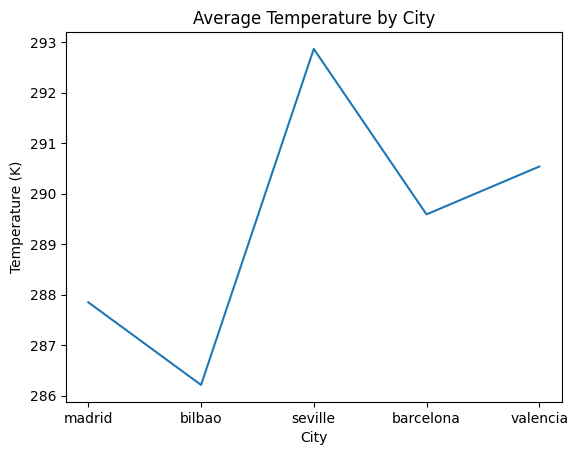

In [ ]:
cities = ['madrid', 'bilbao', 'seville', 'barcelona', 'valencia']
avg_temps = [weather_df_merged[f'{city}_temp'].mean() for city in cities]

plt.plot(cities, avg_temps)
plt.title("Average Temperature by City")
plt.ylabel("Temperature (K)")
plt.xlabel("City")
plt.show()


# Merging Energy and Weather dataframe

In [ ]:
energy_weather_df = pd.merge(energy_df, weather_df_merged, left_index=True, right_index=True, how='inner')
energy_weather_df.head()

generation biomass  generation fossil brown coal/lignite  \
2015-01-01 00:00:00               449.0                                 328.0   
2015-01-01 01:00:00               448.0                                 323.0   
2015-01-01 02:00:00               438.0                                 254.0   
2015-01-01 03:00:00               428.0                                 187.0   
2015-01-01 04:00:00               410.0                                 178.0   

                     generation fossil gas  generation fossil hard coal  \
2015-01-01 00:00:00                 5196.0                       4755.0   
2015-01-01 01:00:00                 4857.0                       4581.0   
2015-01-01 02:00:00                 4314.0                       4131.0   
2015-01-01 03:00:00                 4130.0                       3840.0   
2015-01-01 04:00:00                 4038.0                       3590.0   

                     generation fossil oil  \
2015-01-01 00:00:00                  158.0   
2015-01-01 01:00:00                  157.0   
2015-01-01 02:00:00                  160.0   
2015-01-01 03:00:00                  156.0   
2015-01-01 04:00:00                  156.0   

                     generation hydro pumped storage consumption  \
2015-01-01 00:00:00                                        920.0   
2015-01-01 01:00:00                                       1164.0   
2015-01-01 02:00:00                                       1503.0   
2015-01-01 03:00:00                                       1826.0   
2015-01-01 04:00:00                                       2109.0   

                     generation hydro run-of-river and poundage  \
2015-01-01 00:00:00                                      1009.0   
2015-01-01 01:00:00                                       973.0   
2015-01-01 02:00:00                                       949.0   
2015-01-01 03:00:00                                       953.0   
2015-01-01 04:00:00                                       952.0   

                     generation hydro water reservoir  generation nuclear  \
2015-01-01 00:00:00                            1658.0              7096.0   
2015-01-01 01:00:00                            1371.0              7099.0   
2015-01-01 02:00:00                             779.0              7098.0   
2015-01-01 03:00:00                             720.0              7097.0   
2015-01-01 04:00:00                             743.0              7098.0   

                     generation other  generation other renewable  \
2015-01-01 00:00:00              43.0                        71.0   
2015-01-01 01:00:00              43.0                        73.0   
2015-01-01 02:00:00              43.0                        75.0   
2015-01-01 03:00:00              43.0                        74.0   
2015-01-01 04:00:00              43.0                        74.0   

                     generation solar  generation waste  \
2015-01-01 00:00:00              50.0             195.0   
2015-01-01 01:00:00              50.0             196.0   
2015-01-01 02:00:00              50.0             191.0   
2015-01-01 03:00:00              42.0             189.0   
2015-01-01 04:00:00              34.0             188.0   

                     generation wind onshore  total load actual  price actual  \
2015-01-01 00:00:00                   5890.0            24382.0         64.92   
2015-01-01 01:00:00                   5461.0            22734.0         64.48   
2015-01-01 02:00:00                   5238.0            21286.0         59.32   
2015-01-01 03:00:00                   4935.0            20264.0         56.04   
2015-01-01 04:00:00                   4618.0            19905.0         53.63   

                     madrid_temp  madrid_temp_min  madrid_temp_max  \
2015-01-01 00:00:00      267.325          267.325          267.325   
2015-01-01 01:00:00      266.186          266.186          266.186   
2015-01-01 02:00:00      266.186          266.186          266.1

In [ ]:
energy_weather_df.head()

generation biomass  generation fossil brown coal/lignite  \
2015-01-01 00:00:00               449.0                                 328.0   
2015-01-01 01:00:00               448.0                                 323.0   
2015-01-01 02:00:00               438.0                                 254.0   
2015-01-01 03:00:00               428.0                                 187.0   
2015-01-01 04:00:00               410.0                                 178.0   

                     generation fossil gas  generation fossil hard coal  \
2015-01-01 00:00:00                 5196.0                       4755.0   
2015-01-01 01:00:00                 4857.0                       4581.0   
2015-01-01 02:00:00                 4314.0                       4131.0   
2015-01-01 03:00:00                 4130.0                       3840.0   
2015-01-01 04:00:00                 4038.0                       3590.0   

                     generation fossil oil  \
2015-01-01 00:00:00                  158.0   
2015-01-01 01:00:00                  157.0   
2015-01-01 02:00:00                  160.0   
2015-01-01 03:00:00                  156.0   
2015-01-01 04:00:00                  156.0   

                     generation hydro pumped storage consumption  \
2015-01-01 00:00:00                                        920.0   
2015-01-01 01:00:00                                       1164.0   
2015-01-01 02:00:00                                       1503.0   
2015-01-01 03:00:00                                       1826.0   
2015-01-01 04:00:00                                       2109.0   

                     generation hydro run-of-river and poundage  \
2015-01-01 00:00:00                                      1009.0   
2015-01-01 01:00:00                                       973.0   
2015-01-01 02:00:00                                       949.0   
2015-01-01 03:00:00                                       953.0   
2015-01-01 04:00:00                                       952.0   

                     generation hydro water reservoir  generation nuclear  \
2015-01-01 00:00:00                            1658.0              7096.0   
2015-01-01 01:00:00                            1371.0              7099.0   
2015-01-01 02:00:00                             779.0              7098.0   
2015-01-01 03:00:00                             720.0              7097.0   
2015-01-01 04:00:00                             743.0              7098.0   

                     generation other  generation other renewable  \
2015-01-01 00:00:00              43.0                        71.0   
2015-01-01 01:00:00              43.0                        73.0   
2015-01-01 02:00:00              43.0                        75.0   
2015-01-01 03:00:00              43.0                        74.0   
2015-01-01 04:00:00              43.0                        74.0   

                     generation solar  generation waste  \
2015-01-01 00:00:00              50.0             195.0   
2015-01-01 01:00:00              50.0             196.0   
2015-01-01 02:00:00              50.0             191.0   
2015-01-01 03:00:00              42.0             189.0   
2015-01-01 04:00:00              34.0             188.0   

                     generation wind onshore  total load actual  price actual  \
2015-01-01 00:00:00                   5890.0            24382.0         64.92   
2015-01-01 01:00:00                   5461.0            22734.0         64.48   
2015-01-01 02:00:00                   5238.0            21286.0         59.32   
2015-01-01 03:00:00                   4935.0            20264.0         56.04   
2015-01-01 04:00:00                   4618.0            19905.0         53.63   

                     madrid_temp  madrid_temp_min  madrid_temp_max  \
2015-01-01 00:00:00      267.325          267.325          267.325   
2015-01-01 01:00:00      266.186          266.186          266.186   
2015-01-01 02:00:00      266.186          266.186          266.1

In [ ]:
# Reset the index and rename the index column
energy_weather_df.reset_index(inplace=True)
energy_weather_df.rename(columns={'index': 'hour'}, inplace=True)


In [ ]:
energy_weather_df=energy_weather_df.set_index('hour')

In [ ]:
energy_weather_df.head()

generation biomass  generation fossil brown coal/lignite  \
hour                                                                            
2015-01-01 00:00:00               449.0                                 328.0   
2015-01-01 01:00:00               448.0                                 323.0   
2015-01-01 02:00:00               438.0                                 254.0   
2015-01-01 03:00:00               428.0                                 187.0   
2015-01-01 04:00:00               410.0                                 178.0   

                     generation fossil gas  generation fossil hard coal  \
hour                                                                      
2015-01-01 00:00:00                 5196.0                       4755.0   
2015-01-01 01:00:00                 4857.0                       4581.0   
2015-01-01 02:00:00                 4314.0                       4131.0   
2015-01-01 03:00:00                 4130.0                       3840.0   
2015-01-01 04:00:00                 4038.0                       3590.0   

                     generation fossil oil  \
hour                                         
2015-01-01 00:00:00                  158.0   
2015-01-01 01:00:00                  157.0   
2015-01-01 02:00:00                  160.0   
2015-01-01 03:00:00                  156.0   
2015-01-01 04:00:00                  156.0   

                     generation hydro pumped storage consumption  \
hour                                                               
2015-01-01 00:00:00                                        920.0   
2015-01-01 01:00:00                                       1164.0   
2015-01-01 02:00:00                                       1503.0   
2015-01-01 03:00:00                                       1826.0   
2015-01-01 04:00:00                                       2109.0   

                     generation hydro run-of-river and poundage  \
hour                                                              
2015-01-01 00:00:00                                      1009.0   
2015-01-01 01:00:00                                       973.0   
2015-01-01 02:00:00                                       949.0   
2015-01-01 03:00:00                                       953.0   
2015-01-01 04:00:00                                       952.0   

                     generation hydro water reservoir  generation nuclear  \
hour                                                                        
2015-01-01 00:00:00                            1658.0              7096.0   
2015-01-01 01:00:00                            1371.0              7099.0   
2015-01-01 02:00:00                             779.0              7098.0   
2015-01-01 03:00:00                             720.0              7097.0   
2015-01-01 04:00:00                             743.0              7098.0   

                     generation other  generation other renewable  \
hour                                                                
2015-01-01 00:00:00              43.0                        71.0   
2015-01-01 01:00:00              43.0                        73.0   
2015-01-01 02:00:00              43.0                        75.0   
2015-01-01 03:00:00              43.0                        74.0   
2015-01-01 04:00:00              43.0                        74.0   

                     generation solar  generation waste  \
hour                                                      
2015-01-01 00:00:00              50.0             195.0   
2015-01-01 01:00:00              50.0             196.0   
2015-01-01 02:00:00              50.0             191.0   
2015-01-01 03:00:00              42.0             189.0   
2015-01-01 04:00:00              34.0             188.0   

                     generation wind onshore  total load actual  price actual  \
hour                                                                            
2015-01-01 00:00:00                   5890.0            2

In [ ]:
energy_weather_df = energy_weather_df[~energy_weather_df.index.duplicated(keep='first')]
monthly_load = energy_weather_df['total load actual'].asfreq('M')


In [ ]:
# Checking for duplicate rows in the DataFrame
duplicates = energy_weather_df.duplicated()

# Counting the number of duplicate rows
num_duplicates = duplicates.sum()

# Displaying the number of duplicates
print(f"Number of duplicate rows: {num_duplicates}")

# Optionally, to see the duplicate rows:
if num_duplicates > 0:
    print("Duplicate rows:")
    print(energy_weather_df[duplicates])


Number of duplicate rows: 0


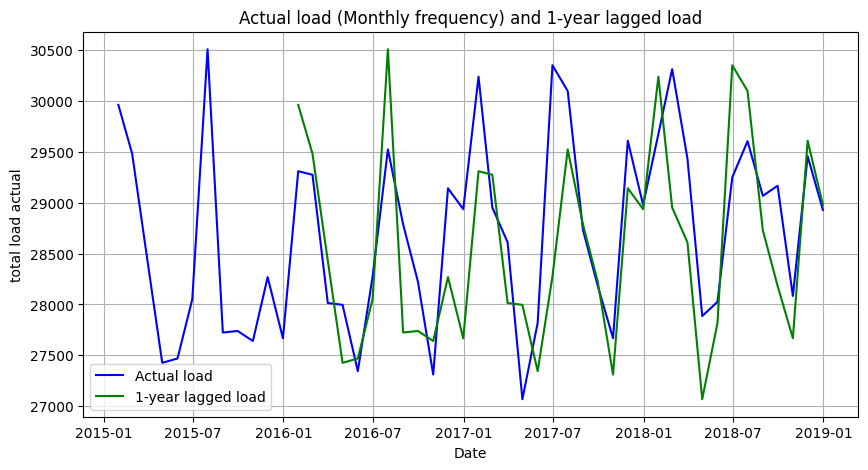

In [ ]:
monthly_load = energy_weather_df['total load actual'].resample('M').mean()
shifted = monthly_load.shift(12)

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_load, label='Actual load ', color='blue')
plt.plot(shifted, label='1-year lagged load', color='green')
plt.title('Actual load (Monthly frequency) and 1-year lagged load')
plt.ylabel('total load actual')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

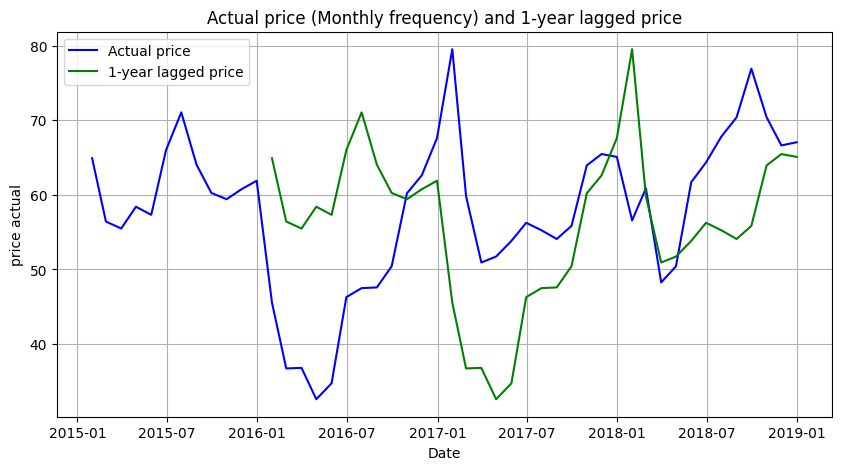

In [ ]:
monthly_price = energy_weather_df['price actual'].resample('M').mean()
shifted = monthly_price.shift(12)

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_price, label='Actual price ', color='blue')
plt.plot(shifted, label='1-year lagged price', color='green')
plt.title('Actual price (Monthly frequency) and 1-year lagged price')
plt.ylabel('price actual')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
correlations = energy_weather_df.corr(method='pearson')
print(correlations['price actual'].sort_values(ascending=False).to_string())

price actual                                   1.000000
generation fossil hard coal                    0.465646
generation fossil gas                          0.461431
total load actual                              0.435589
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285088
generation other renewable                     0.255561
bilbao_pressure                                0.194046
generation waste                               0.168763
generation biomass                             0.142678
valencia_temp_min                              0.133199
barcelona_temp_min                             0.103745
generation other                               0.099890
generation solar                               0.098544
madrid_temp_max                                0.096321
valencia_temp                                  0.090558
seville_pressure                               0.089861
madrid_temp                                    0

In [ ]:
energy_weather_df = energy_weather_df.drop(['barcelona_snow_3h', 'seville_snow_3h'],
                        axis=1)

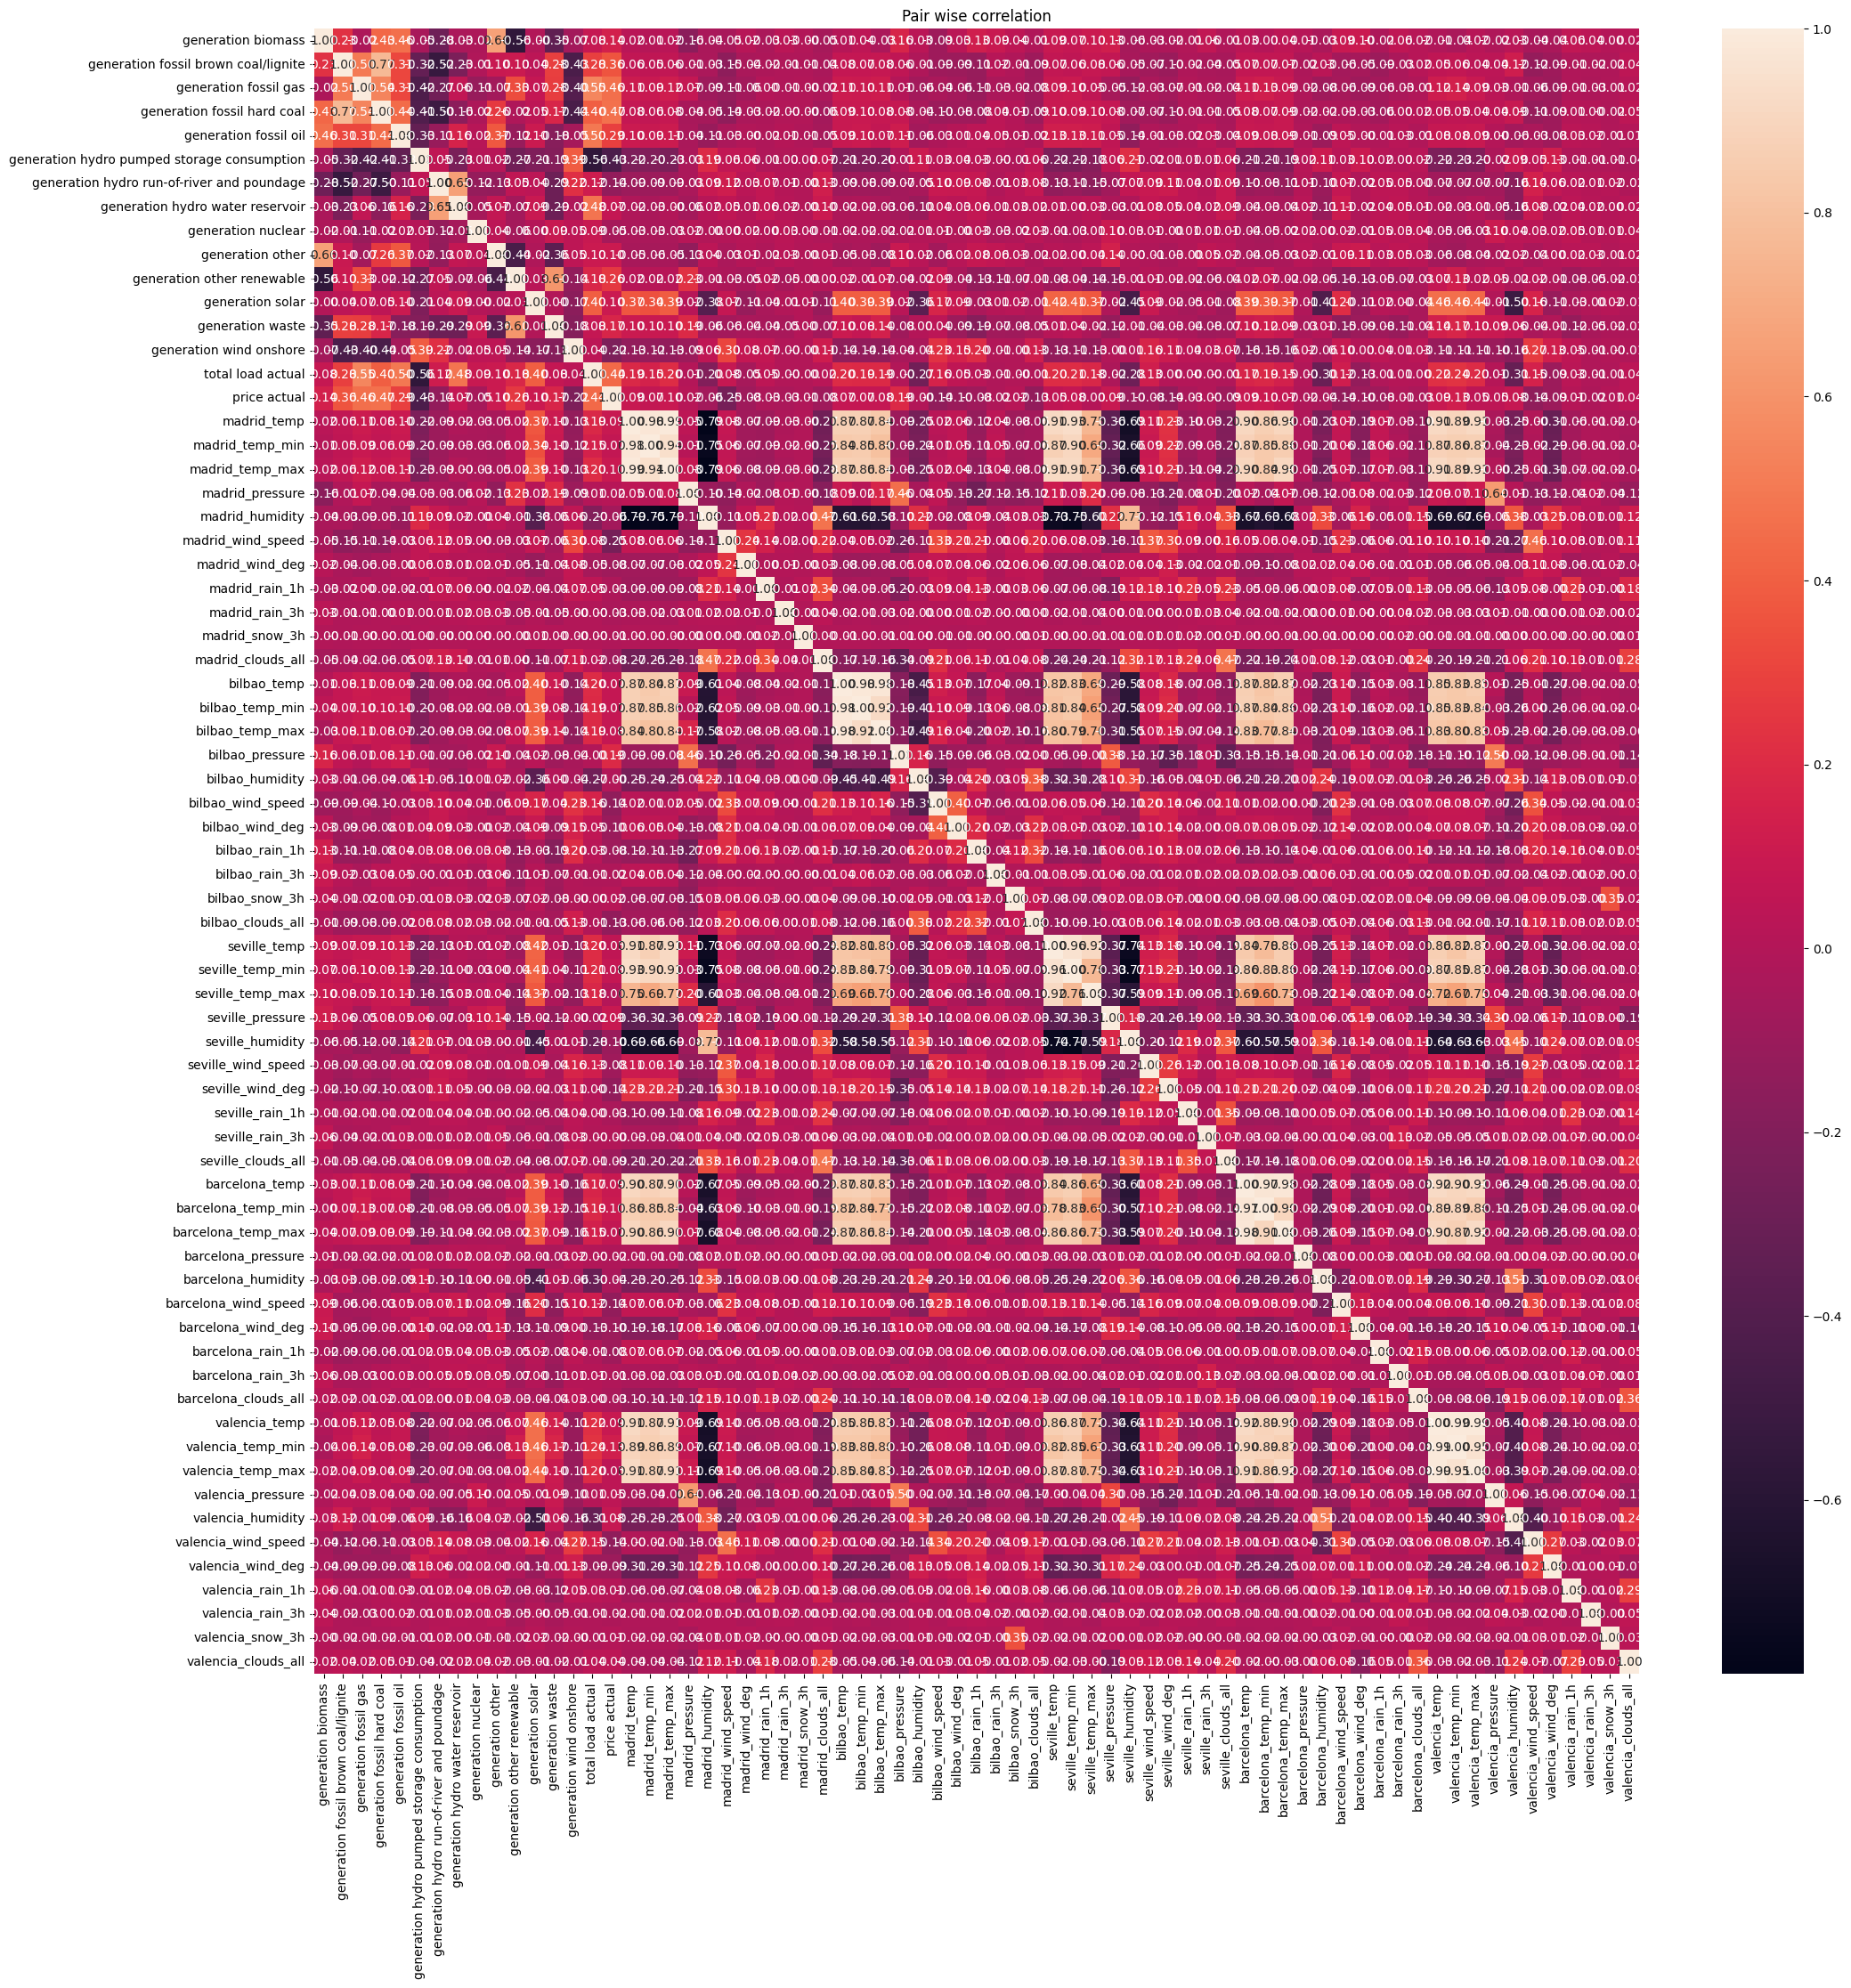

In [ ]:
# Plot pair wise correlation matrix

correlations = energy_weather_df.corr(method='pearson')
fig = plt.figure(figsize=(24,24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pair wise correlation')
plt.show()

In [ ]:

for i in range(len(energy_weather_df)):
    position = energy_weather_df.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    energy_weather_df.loc[position, 'hour'] = hour
    energy_weather_df.loc[position, 'weekday'] = weekday
    energy_weather_df.loc[position, 'month'] = month

In [ ]:

for i in range(len(energy_weather_df)):
    position = energy_weather_df.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        energy_weather_df.loc[position, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        energy_weather_df.loc[position, 'business hour'] = 1
    else:
        energy_weather_df.loc[position, 'business hour'] = 0

In [ ]:
energy_weather_df.head(5)

generation biomass  generation fossil brown coal/lignite  \
hour                                                                            
2015-01-01 00:00:00               449.0                                 328.0   
2015-01-01 01:00:00               448.0                                 323.0   
2015-01-01 02:00:00               438.0                                 254.0   
2015-01-01 03:00:00               428.0                                 187.0   
2015-01-01 04:00:00               410.0                                 178.0   

                     generation fossil gas  generation fossil hard coal  \
hour                                                                      
2015-01-01 00:00:00                 5196.0                       4755.0   
2015-01-01 01:00:00                 4857.0                       4581.0   
2015-01-01 02:00:00                 4314.0                       4131.0   
2015-01-01 03:00:00                 4130.0                       3840.0   
2015-01-01 04:00:00                 4038.0                       3590.0   

                     generation fossil oil  \
hour                                         
2015-01-01 00:00:00                  158.0   
2015-01-01 01:00:00                  157.0   
2015-01-01 02:00:00                  160.0   
2015-01-01 03:00:00                  156.0   
2015-01-01 04:00:00                  156.0   

                     generation hydro pumped storage consumption  \
hour                                                               
2015-01-01 00:00:00                                        920.0   
2015-01-01 01:00:00                                       1164.0   
2015-01-01 02:00:00                                       1503.0   
2015-01-01 03:00:00                                       1826.0   
2015-01-01 04:00:00                                       2109.0   

                     generation hydro run-of-river and poundage  \
hour                                                              
2015-01-01 00:00:00                                      1009.0   
2015-01-01 01:00:00                                       973.0   
2015-01-01 02:00:00                                       949.0   
2015-01-01 03:00:00                                       953.0   
2015-01-01 04:00:00                                       952.0   

                     generation hydro water reservoir  generation nuclear  \
hour                                                                        
2015-01-01 00:00:00                            1658.0              7096.0   
2015-01-01 01:00:00                            1371.0              7099.0   
2015-01-01 02:00:00                             779.0              7098.0   
2015-01-01 03:00:00                             720.0              7097.0   
2015-01-01 04:00:00                             743.0              7098.0   

                     generation other  generation other renewable  \
hour                                                                
2015-01-01 00:00:00              43.0                        71.0   
2015-01-01 01:00:00              43.0                        73.0   
2015-01-01 02:00:00              43.0                        75.0   
2015-01-01 03:00:00              43.0                        74.0   
2015-01-01 04:00:00              43.0                        74.0   

                     generation solar  generation waste  \
hour                                                      
2015-01-01 00:00:00              50.0             195.0   
2015-01-01 01:00:00              50.0             196.0   
2015-01-01 02:00:00              50.0             191.0   
2015-01-01 03:00:00              42.0             189.0   
2015-01-01 04:00:00              34.0             188.0   

                     generation wind onshore  total load actual  price actual  \
hour                                                                            
2015-01-01 00:00:00                   5890.0            2

In [ ]:
for i in range(len(energy_weather_df)):
    position = energy_weather_df.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        energy_weather_df.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        energy_weather_df.loc[position, 'weekday'] = 1
    else:
        energy_weather_df.loc[position, 'weekday'] = 0

In [ ]:
energy_weather_df['generation coal all'] = energy_weather_df['generation fossil hard coal'] + energy_weather_df['generation fossil brown coal/lignite']
energy_weather_df.head(5)
energy_weather_df.shape

(35063, 74)

# Model Development

In [ ]:
target_date=energy_weather_df.index[26305]
print(f'target_date={target_date}')
#energy_weather_df.loc[target_date]

target_date=2018-01-01 01:00:00


In [ ]:
training_end_idx = 26304

## Total Load Predict Function

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END ..learning_rate=0.02, max_depth=3, n_estimators=100; total time=   2.2s
[CV] END ..learning_rate=0.02, max_depth=3, n_estimators=100; total time=   2.1s
[CV] END ..learning_rate=0.02, max_depth=3, n_estimators=150; total time=   0.6s
[CV] END ..learning_rate=0.02, max_depth=3, n_estimators=150; total time=   0.7s
[CV] END ..learning_rate=0.02, max_depth=7, n_estimators=100; total time=   2.5s
[CV] END ..learning_rate=0.02, max_depth=7, n_estimators=100; total time=   3.1s
[CV] END ..learning_rate=0.02, max_depth=7, n_estimators=150; total time=   4.9s
[CV] END ..learning_rate=0.02, max_depth=7, n_estimators=150; total time=   7.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=150; total time=   0.6s
[CV] END ..learning_rate=0.05, max_depth=3, n_est

Evaluating models:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 1s 819ms/step


Evaluating models:  10%|█         | 1/10 [06:29<58:22, 389.17s/it]

2/2 [==============================] - 0s 8ms/step


Evaluating models:  20%|██        | 2/10 [11:59<47:15, 354.43s/it]

3/3 [==============================] - 0s 5ms/step


Evaluating models:  30%|███       | 3/10 [17:25<39:49, 341.40s/it]

3/3 [==============================] - 0s 5ms/step


Evaluating models:  40%|████      | 4/10 [22:56<33:44, 337.37s/it]

4/4 [==============================] - 0s 4ms/step


Evaluating models:  50%|█████     | 5/10 [28:28<27:58, 335.65s/it]

5/5 [==============================] - 0s 3ms/step


Evaluating models:  60%|██████    | 6/10 [34:49<23:23, 350.94s/it]

6/6 [==============================] - 0s 3ms/step


Evaluating models:  70%|███████   | 7/10 [41:10<18:02, 360.69s/it]

23/23 [==============================] - 0s 2ms/step


Evaluating models:  80%|████████  | 8/10 [46:48<11:46, 353.43s/it]

135/135 [==============================] - 0s 2ms/step


Evaluating models:  90%|█████████ | 9/10 [52:20<05:46, 346.75s/it]

274/274 [==============================] - 1s 2ms/step


Evaluating models: 100%|██████████| 10/10 [58:43<00:00, 352.37s/it]


{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
-0.005808085390547394
Test Size: 1st Day
Linear Regression:
  NMAE: 0.3678031174533943
  NMSE: 0.16189073555673567
  R2: 0.4540136411086195
  TSO_NMSE: 0.017849493317203362

Random Forest:
  NMAE: 0.5509581811164268
  NMSE: 0.2772643974047924
  R2: 0.06490894448865925
  TSO_NMSE: 0.017849493317203362

LSTM:
  NMAE: 0.34116864069745384
  NMSE: 0.10543184341188856
  R2: 0.6444246911492386
  TSO_NMSE: 0.017849493317203362

XGBoost:
  NMAE: 0.6447831664628403
  NMSE: 0.3451874111149687
  R2: -0.16416555327685245
  TSO_NMSE: 0.017849493317203362

Test Size: 2nd Day
Linear Regression:
  NMAE: 0.21088675081859448
  NMSE: 0.044180134553170776
  R2: 0.8551528991739143
  TSO_NMSE: 0.004158717391666088

Random Forest:
  NMAE: 0.23231108949167284
  NMSE: 0.04749940125856235
  R2: 0.8442704932236587
  TSO_NMSE: 0.004158717391666088

LSTM:
  NMAE: 0.18176688866811783
  NMSE: 0.02995714204776403
  R2: 0.9017837944918069
  TSO_NMSE: 0.004158

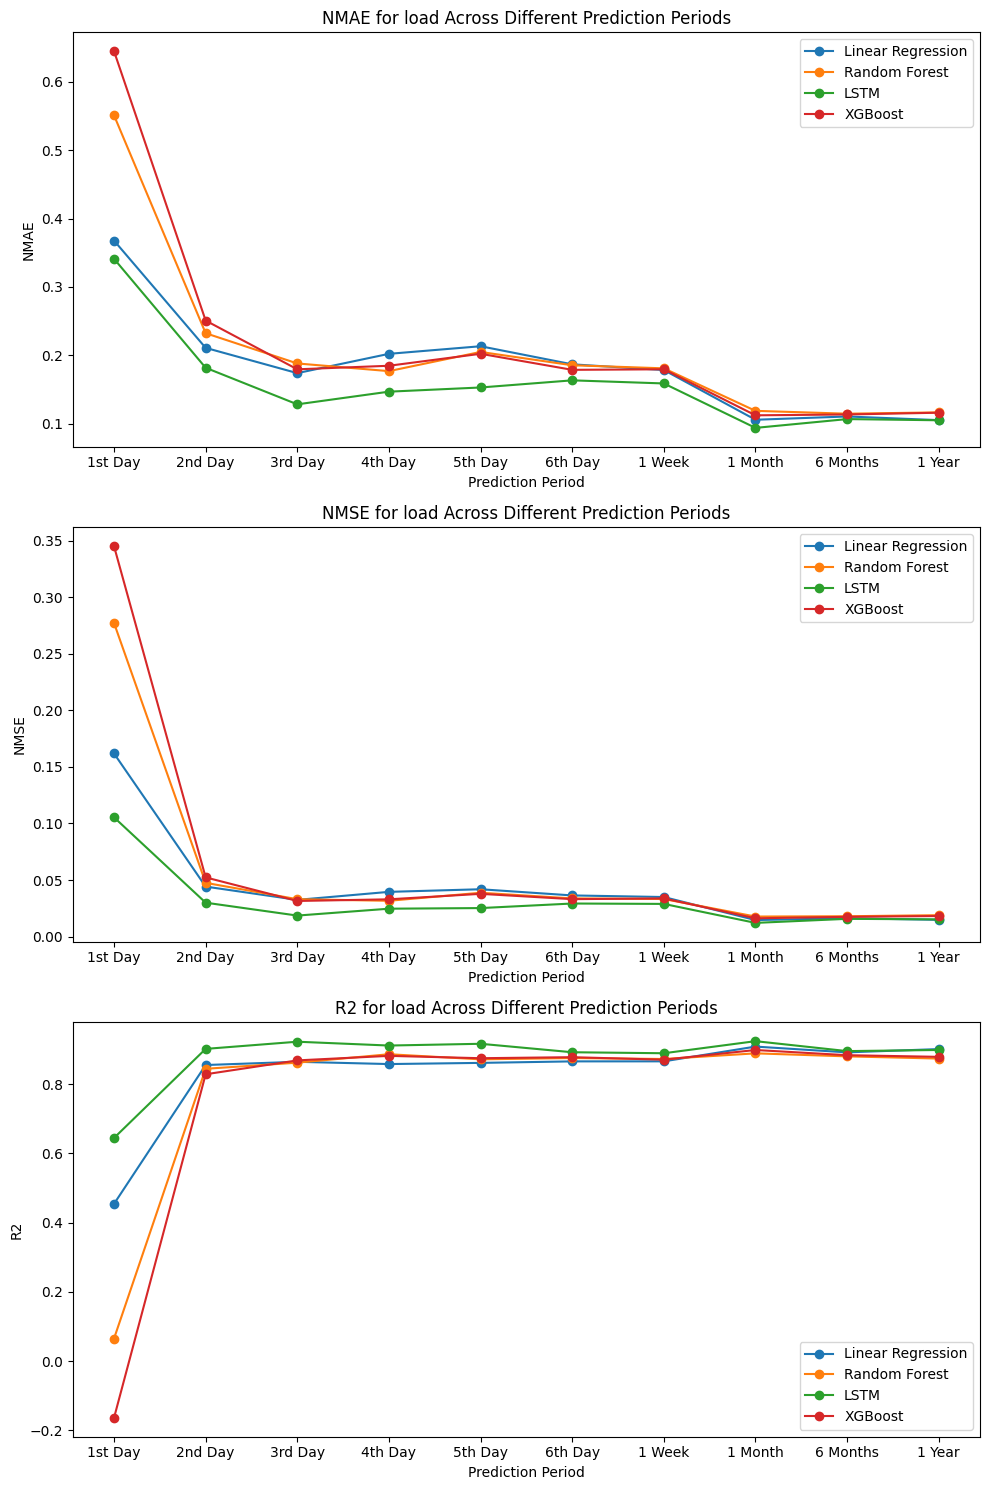

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm  # Import tqdm for the progress bar

def normalize_data(df):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(df.drop(columns=['total load actual']))
    y_scaled = scaler_y.fit_transform(df[['total load actual']])
    return X_scaled, y_scaled, scaler_X, scaler_y

def evaluate_models(energy_weather_df, forecast, training_end_idx):
    # Define detailed test sizes
    test_sizes = {
        '1st Day': 24,
        '2nd Day': 24 * 2,
        '3rd Day': 24 * 3,
        '4th Day': 24 * 4,
        '5th Day': 24 * 5,
        '6th Day': 24 * 6,
        '1 Week': 7 * 24,
        '1 Month': 30 * 24,
        '6 Months': 180 * 24,
        '1 Year': len(energy_weather_df) - training_end_idx  # All remaining data
    }
    results = {}
    X_scaled, y_scaled, _, _ = normalize_data(energy_weather_df)
    y = y_scaled.flatten()
    X_train = X_scaled[:training_end_idx]
    y_train = y[:training_end_idx]

    # Initialize models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
        'LSTM': Sequential([
            LSTM(50, return_sequences=True, input_shape=(1, X_train.shape[1])),
            LSTM(50),
            Dense(1)
        ])
    }
    models['LSTM'].compile(optimizer='adam', loss='mean_squared_error')

    xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
    param_grid = {
        'max_depth': [3, 7],
        'learning_rate': [0.02, 0.05],
        'n_estimators': [100, 150]
    }
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', verbose=2, n_jobs=1)
    grid_search.fit(X_train, y_train)
    models['XGBoost'] = grid_search.best_estimator_

    for name, test_size in tqdm(test_sizes.items(), desc="Evaluating models"):
        test_end_idx = training_end_idx + test_size
        X_test = X_scaled[training_end_idx:test_end_idx]
        y_test = y[training_end_idx:test_end_idx]
        tso_load = forecast['total load forecast'][training_end_idx:test_end_idx]
        X_test_lstm = np.array(X_test).reshape(-1, 1, X_test.shape[1])

        results[name] = {}
        for model_name, model in models.items():
            if model_name == 'LSTM':
                model.fit(X_train.reshape(-1, 1, X_train.shape[1]), y_train, epochs=75, batch_size=32, verbose=0)
                y_pred = model.predict(X_test_lstm).flatten()
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

            results[name][model_name] = {
                'NMAE': mean_absolute_error(y_test, y_pred) / np.mean(y_test),
                'NMSE': mean_squared_error(y_test, y_pred) / np.mean(np.square(y_test)),
                'R2': r2_score(y_test, y_pred),
                'TSO_NMSE': mean_squared_error(y_test, tso_load) / np.mean(np.square(y_test))
            }
    print(grid_search.best_params_)
    print(grid_search.best_score_)
    return results, models

# Set the training_end_idx
training_end_idx = 26304  # Updated index

# Call the evaluate_models function
load_evaluation_results, models = evaluate_models(energy_weather_df, forecast, training_end_idx)

# Print the evaluation results
for test_size, test_results in load_evaluation_results.items():
    print(f"Test Size: {test_size}")
    for model_name, metrics in test_results.items():
        print(f"{model_name}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value}")
        print()

# Create plots for each metric across different prediction periods
metrics_to_plot = ['NMAE', 'NMSE', 'R2']
colors = ['blue', 'green', 'red']
fig, axs = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 15))

for i, metric in enumerate(metrics_to_plot):
    for model_name in models.keys():
        metric_values = [load_evaluation_results[test_size][model_name][metric] for test_size in load_evaluation_results]
        test_sizes = list(load_evaluation_results.keys())
        axs[i].plot(test_sizes, metric_values, marker='o', label=model_name)

    axs[i].set_title(f'{metric} for load Across Different Prediction Periods')
    axs[i].set_xlabel('Prediction Period')
    axs[i].set_ylabel(metric)
    axs[i].legend()

plt.tight_layout()
plt.show()


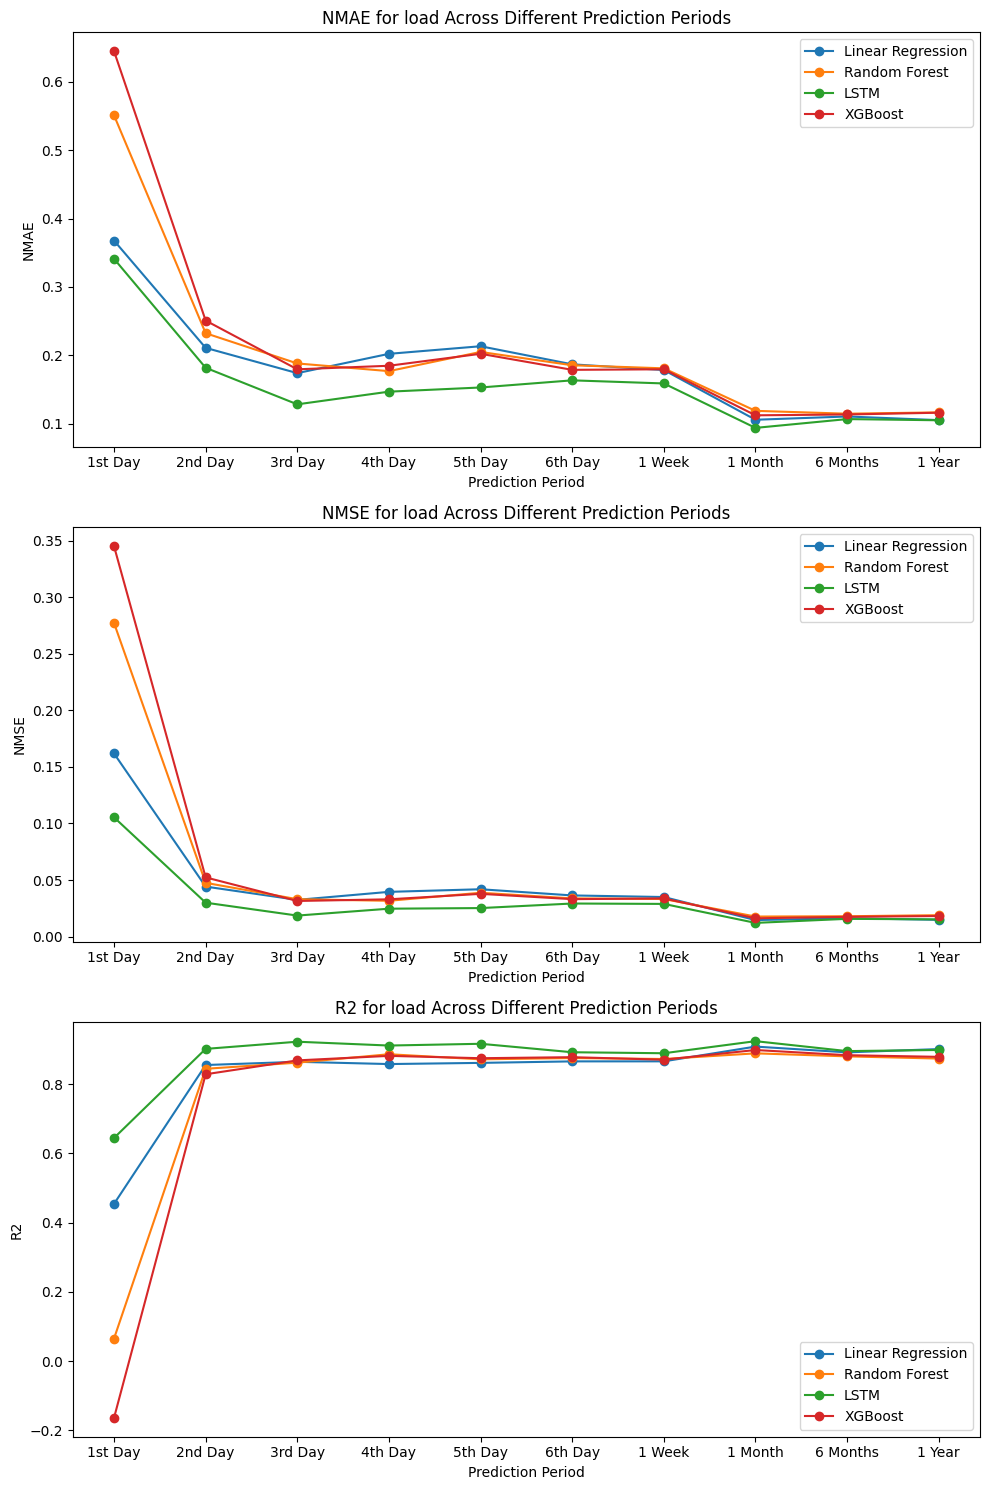

In [ ]:
# Create plots for each metric across different prediction periods
metrics_to_plot = ['NMAE', 'NMSE', 'R2']
colors = ['blue', 'green', 'red', 'brown']
fig, axs = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 15))

for i, metric in enumerate(metrics_to_plot):
    for model_name in models.keys():
        metric_values = [load_evaluation_results[test_size][model_name][metric] for test_size in load_evaluation_results]
        test_sizes = list(load_evaluation_results.keys())
        axs[i].plot(test_sizes, metric_values, marker='o', label=model_name)

    axs[i].set_title(f'{metric} for load Across Different Prediction Periods')
    axs[i].set_xlabel('Prediction Period')
    axs[i].set_ylabel(metric)
    axs[i].legend()

plt.tight_layout()
plt.show()



## Predicted Load Comparison with TSO

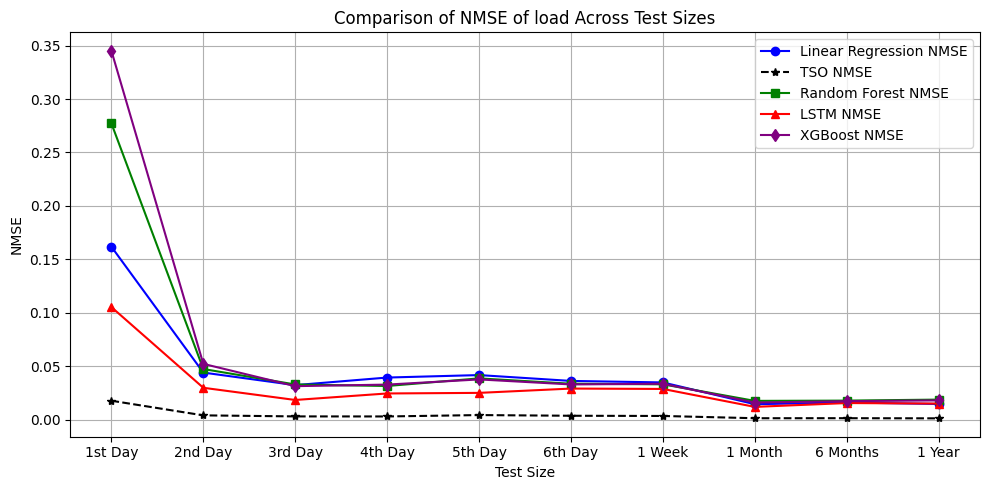

In [ ]:
import matplotlib.pyplot as plt

def compare_tso_with_other_models_line_plot(load_evaluation_results):
    # This function will plot line comparisons of TSO_NMSE with other models' NMSE for each test size.
    test_sizes = list(load_evaluation_results.keys())
    models = list(next(iter(load_evaluation_results.values())).keys())

    # Prepare the figure
    fig, ax = plt.subplots(figsize=(10, 5))

    markers = ['o', 's', '^', 'd', '*']
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    for i, model in enumerate(models):
        nmse_values = [load_evaluation_results[test_size][model]['NMSE'] for test_size in test_sizes]
        tso_nmse_values = [load_evaluation_results[test_size][model]['TSO_NMSE'] for test_size in test_sizes]

        # Line plot for model NMSE
        ax.plot(test_sizes, nmse_values, marker=markers[i % len(markers)], color=colors[i % len(colors)], label=f'{model} NMSE')

        # Line plot for TSO NMSE
        if model == models[0]:
            ax.plot(test_sizes, tso_nmse_values, marker=markers[-1], color='black', linestyle='--', label='TSO NMSE')

    ax.set_xlabel('Test Size')
    ax.set_ylabel('NMSE')
    ax.set_title('Comparison of NMSE of load Across Test Sizes')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()


compare_tso_with_other_models_line_plot(load_evaluation_results)


Processing Metrics: 100%|██████████| 3/3 [00:00<00:00, 19.07it/s]


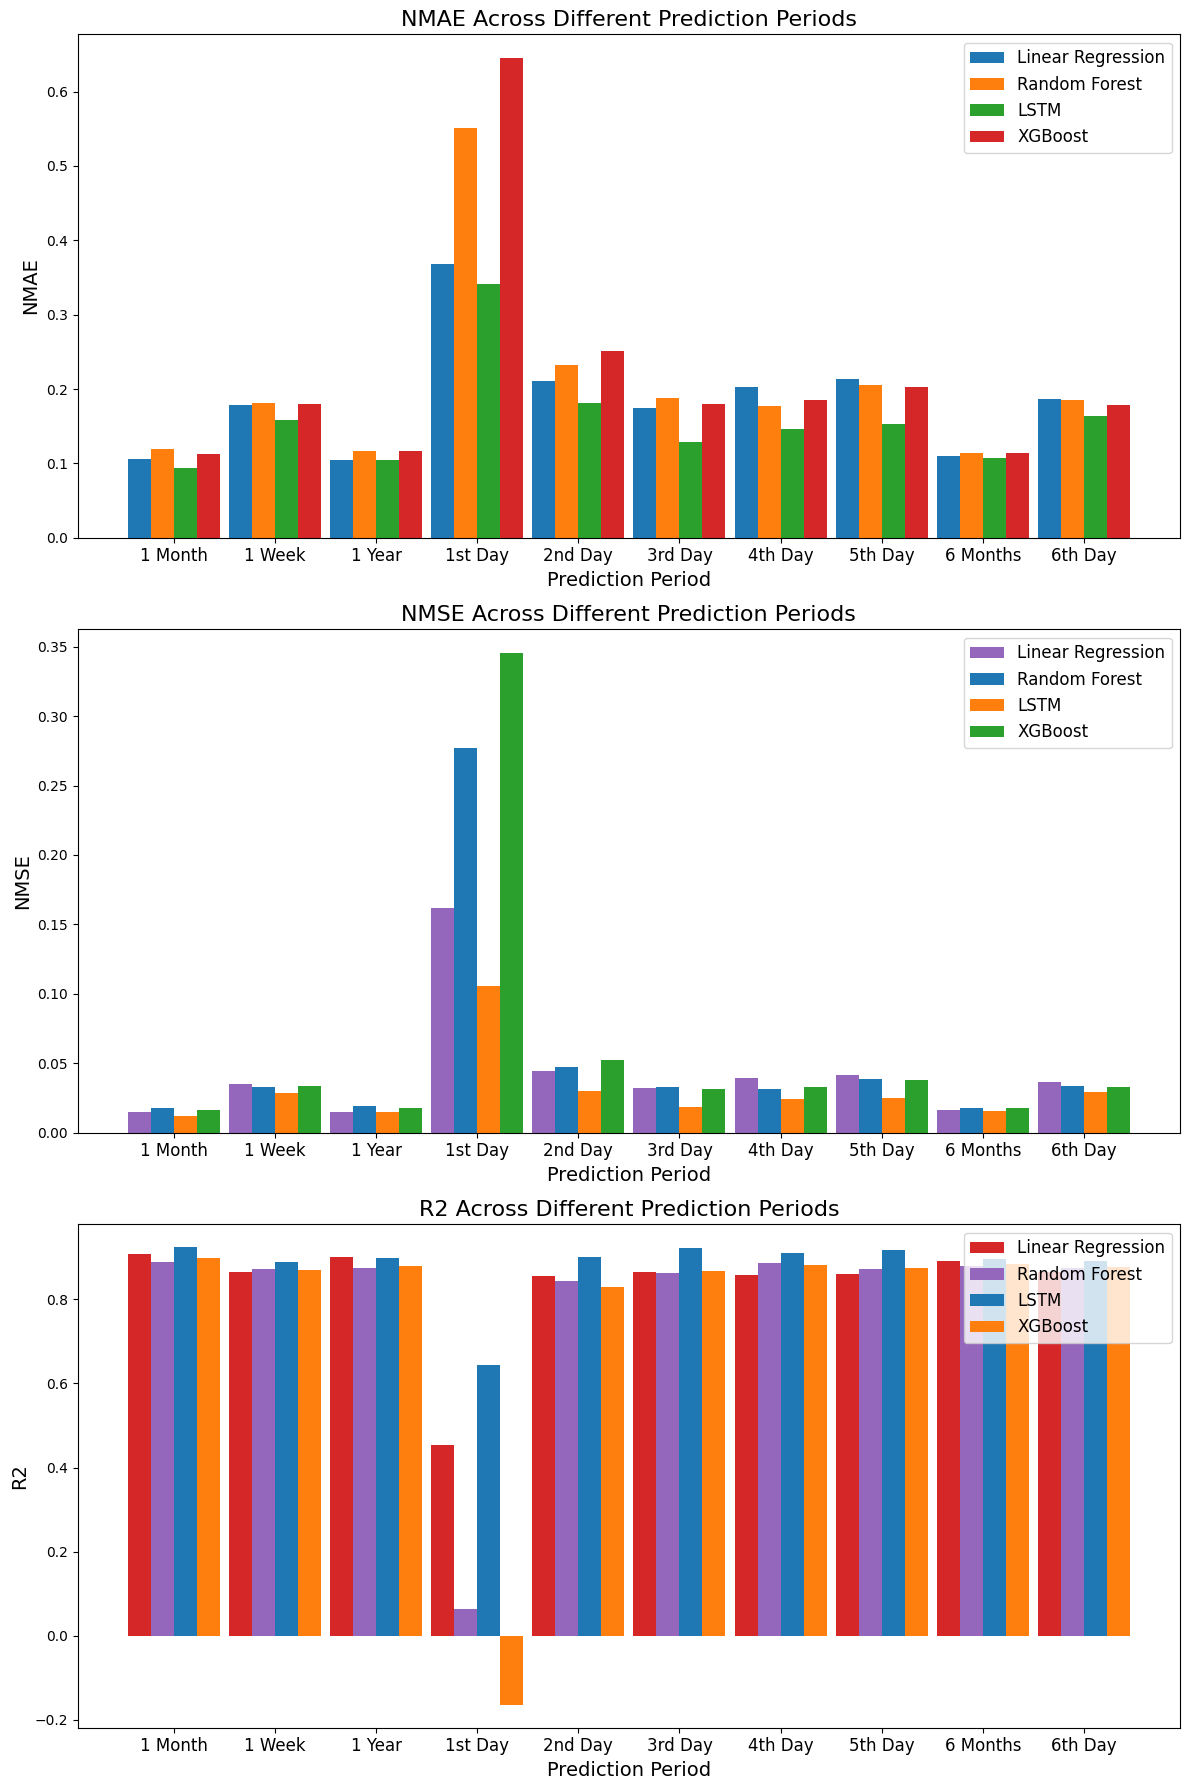

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from tqdm import tqdm  # Import tqdm for the progress bar

# Define metrics to plot
metrics_to_plot = ['NMAE', 'NMSE', 'R2']
# Define a vibrant color palette
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
# Prepare the figure layout
fig, axs = plt.subplots(len(metrics_to_plot), 1, figsize=(12, 18))

# Padding between groups of bars
bar_width = 0.25
# Define additional space between groups
group_spacing = 0.1

prediction_periods = sorted(load_evaluation_results.keys())
num_models = len(models)
# Array of prediction period indices, modified to include group spacing
index = np.arange(len(prediction_periods)) * (num_models * bar_width + group_spacing)

# Iterate over metrics with a progress bar
for i, metric in enumerate(tqdm(metrics_to_plot, desc="Processing Metrics")):
    for j, model_name in enumerate(models.keys()):
        # Collect metric values for each prediction period, ensuring all are included
        metric_values = [load_evaluation_results.get(period, {}).get(model_name, {}).get(metric, np.nan) for period in prediction_periods]
        # Calculate the position for the bars for this model
        positions = index + bar_width * j

        axs[i].bar(positions, metric_values, bar_width, label=model_name, color=next(colors))

    axs[i].set_title(f'{metric} Across Different Prediction Periods', fontsize=16)
    axs[i].set_xlabel('Prediction Period', fontsize=14)
    axs[i].set_ylabel(metric, fontsize=14)
    axs[i].set_xticks(index + bar_width * (num_models - 1) / 2)
    axs[i].set_xticklabels(prediction_periods, fontsize=12)
    axs[i].legend(fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


##Total Price Predict Function

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm  # Import tqdm for the progress bar

def normalize_data(df):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(df.drop(columns=['price actual']))
    y_scaled = scaler_y.fit_transform(df[['price actual']])
    return X_scaled, y_scaled, scaler_X, scaler_y

def evaluate_models(energy_weather_df, forecast, training_end_idx):
    # Define detailed test sizes as requested
    test_sizes = {
        '1st Day': 24,
        '2nd Day': 24 * 2,
        '3rd Day': 24 * 3,
        '4th Day': 24 * 4,
        '5th Day': 24 * 5,
        '6th Day': 24 * 6,
        '1 Week': 7 * 24,
        '1 Month': 30 * 24,
        '6 Months': 180 * 24,
        '1 Year': len(energy_weather_df) - training_end_idx  # All remaining data
    }
    results = {}
    X_scaled, y_scaled, _, _ = normalize_data(energy_weather_df)
    y = y_scaled.flatten()
    X_train = X_scaled[:training_end_idx]
    y_train = y[:training_end_idx]

    # Initialize models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
        'LSTM': Sequential([
            LSTM(50, return_sequences=True, input_shape=(1, X_train.shape[1])),
            LSTM(50),
            Dense(1)
        ])
    }
    models['LSTM'].compile(optimizer='adam', loss='mean_squared_error')

    xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
    param_grid = {
        'max_depth': [3, 7],
        'learning_rate': [0.02, 0.05],
        'n_estimators': [100, 150]
    }
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', verbose=2, n_jobs=1)
    grid_search.fit(X_train, y_train)
    models['XGBoost'] = grid_search.best_estimator_

    for name, test_size in tqdm(test_sizes.items(), desc="Evaluating models"):
        test_end_idx = training_end_idx + test_size
        X_test = X_scaled[training_end_idx:test_end_idx]
        y_test = y[training_end_idx:test_end_idx]
        tso_price = forecast['price day ahead'][training_end_idx:test_end_idx]
        X_test_lstm = np.array(X_test).reshape(-1, 1, X_test.shape[1])

        results[name] = {}
        for model_name, model in models.items():
            if model_name == 'LSTM':
                model.fit(X_train.reshape(-1, 1, X_train.shape[1]), y_train, epochs=75, batch_size=32, verbose=0)
                y_pred = model.predict(X_test_lstm).flatten()
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

            results[name][model_name] = {
                'NMAE': mean_absolute_error(y_test, y_pred) / np.mean(y_test),
                'NMSE': mean_squared_error(y_test, y_pred) / np.mean(np.square(y_test)),
                'R2': r2_score(y_test, y_pred),
                'TSO_NMSE': mean_squared_error(y_test, tso_price) / np.mean(np.square(y_test))
            }
    print("the best hyper parameters: ", grid_search.best_params_)
    print(grid_search.best_score_)
    return results, models

# Set the training_end_idx
training_end_idx = 26304  # Updated index

# Call the evaluate_models function
price_evaluation_results, models = evaluate_models(energy_weather_df, forecast, training_end_idx)

# Print the evaluation results
for test_size, test_results in price_evaluation_results.items():
    print(f"Test Size: {test_size}")
    for model_name, metrics in test_results.items():
        print(f"{model_name}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value}")
        print()




Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END ..learning_rate=0.02, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.02, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.02, max_depth=3, n_estimators=150; total time=   0.6s
[CV] END ..learning_rate=0.02, max_depth=3, n_estimators=150; total time=   0.7s
[CV] END ..learning_rate=0.02, max_depth=7, n_estimators=100; total time=   5.2s
[CV] END ..learning_rate=0.02, max_depth=7, n_estimators=100; total time=   2.8s
[CV] END ..learning_rate=0.02, max_depth=7, n_estimators=150; total time=   3.4s
[CV] END ..learning_rate=0.02, max_depth=7, n_estimators=150; total time=   6.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   1.6s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=150; total time=   0.6s
[CV] END ..learning_rate=0.05, max_depth=3, n_est

Evaluating models:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 1s 747ms/step


Evaluating models:  10%|█         | 1/10 [05:45<51:51, 345.73s/it]

2/2 [==============================] - 0s 5ms/step


Evaluating models:  20%|██        | 2/10 [11:25<45:38, 342.28s/it]

3/3 [==============================] - 0s 6ms/step


Evaluating models:  30%|███       | 3/10 [17:53<42:22, 363.27s/it]

3/3 [==============================] - 0s 7ms/step


Evaluating models:  40%|████      | 4/10 [24:20<37:14, 372.41s/it]

4/4 [==============================] - 0s 4ms/step


Evaluating models:  50%|█████     | 5/10 [29:51<29:47, 357.58s/it]

5/5 [==============================] - 0s 4ms/step


Evaluating models:  60%|██████    | 6/10 [35:30<23:25, 351.36s/it]

6/6 [==============================] - 0s 4ms/step


Evaluating models:  70%|███████   | 7/10 [41:09<17:21, 347.25s/it]

23/23 [==============================] - 0s 2ms/step


Evaluating models:  80%|████████  | 8/10 [46:45<11:26, 343.48s/it]

135/135 [==============================] - 0s 2ms/step


Evaluating models:  90%|█████████ | 9/10 [52:24<05:42, 342.33s/it]

274/274 [==============================] - 1s 3ms/step


Evaluating models: 100%|██████████| 10/10 [57:56<00:00, 347.68s/it]

the best hyper parameters:  {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
-0.01960030770777311
Test Size: 1st Day
Linear Regression:
  NMAE: 1.6544624167477593
  NMSE: 2.319666368473685
  R2: -10.175530299198524
  TSO_NMSE: 0.6255100207804597

Random Forest:
  NMAE: 3.367617338487027
  NMSE: 9.608707481146144
  R2: -45.29217505202729
  TSO_NMSE: 0.6255100207804597

LSTM:
  NMAE: 1.7699108928691938
  NMSE: 2.7860362168100505
  R2: -12.422375122036156
  TSO_NMSE: 0.6255100207804597

XGBoost:
  NMAE: 1.5412129881477563
  NMSE: 2.146037518945865
  R2: -9.33903307913067
  TSO_NMSE: 0.6255100207804597

Test Size: 2nd Day
Linear Regression:
  NMAE: 0.5952651699825088
  NMSE: 0.34849706266274105
  R2: -0.02454844754158736
  TSO_NMSE: 0.3431849503739348

Random Forest:
  NMAE: 1.203329249008586
  NMSE: 1.1520746259262682
  R2: -2.3869905830084597
  TSO_NMSE: 0.3431849503739348

LSTM:
  NMAE: 0.7384471842922424
  NMSE: 0.4377062870978294
  R2: -0.28681514127785723
  TSO_NMSE: 0.34

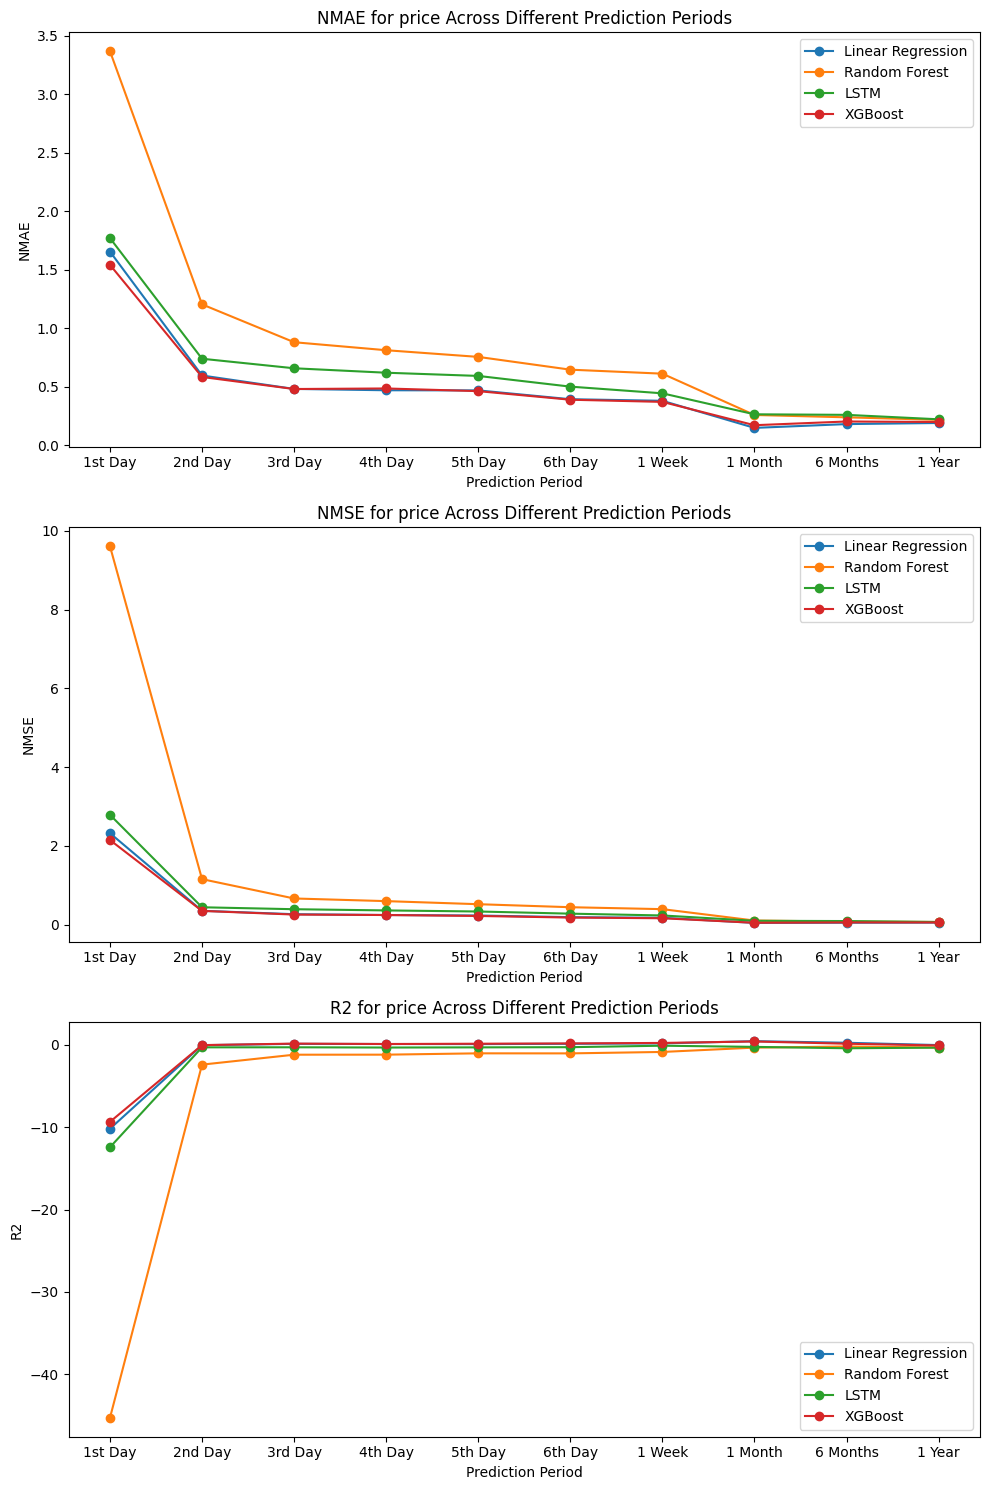

In [ ]:
 # Create plots for each metric across different prediction periods
metrics_to_plot = ['NMAE', 'NMSE', 'R2']
colors = ['blue', 'green', 'red','brown']
fig, axs = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 15))

for i, metric in enumerate(metrics_to_plot):
    for model_name in models.keys():
        metric_values = [price_evaluation_results[test_size][model_name][metric] for test_size in price_evaluation_results]
        test_sizes = list(price_evaluation_results.keys())
        axs[i].plot(test_sizes, metric_values, marker='o', label=model_name)

    axs[i].set_title(f'{metric} for price Across Different Prediction Periods')
    axs[i].set_xlabel('Prediction Period')
    axs[i].set_ylabel(metric)
    axs[i].legend()

plt.tight_layout()
plt.show()

## Predicted Price Comparision with TSO

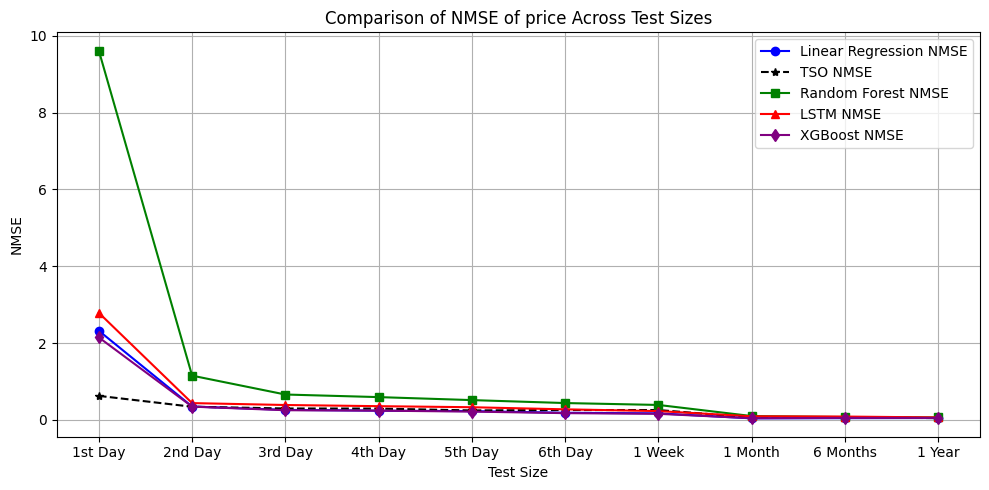

In [ ]:
import matplotlib.pyplot as plt

def compare_tso_with_other_models_line_plot(price_evaluation_results):
    # This function will plot line comparisons of TSO_NMSE with other models' NMSE for each test size.
    test_sizes = list(price_evaluation_results.keys())
    models = list(next(iter(price_evaluation_results.values())).keys())

    # Prepare the figure
    fig, ax = plt.subplots(figsize=(10, 5))

    markers = ['o', 's', '^', 'd', '*']
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    for i, model in enumerate(models):
        nmse_values = [price_evaluation_results[test_size][model]['NMSE'] for test_size in test_sizes]
        tso_nmse_values = [price_evaluation_results[test_size][model]['TSO_NMSE'] for test_size in test_sizes]

        # Line plot for model NMSE
        ax.plot(test_sizes, nmse_values, marker=markers[i % len(markers)], color=colors[i % len(colors)], label=f'{model} NMSE')

        # Line plot for TSO NMSE
        if model == models[0]:
            ax.plot(test_sizes, tso_nmse_values, marker=markers[-1], color='black', linestyle='--', label='TSO NMSE')

    ax.set_xlabel('Test Size')
    ax.set_ylabel('NMSE')
    ax.set_title('Comparison of NMSE of price Across Test Sizes')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()


compare_tso_with_other_models_line_plot(price_evaluation_results)


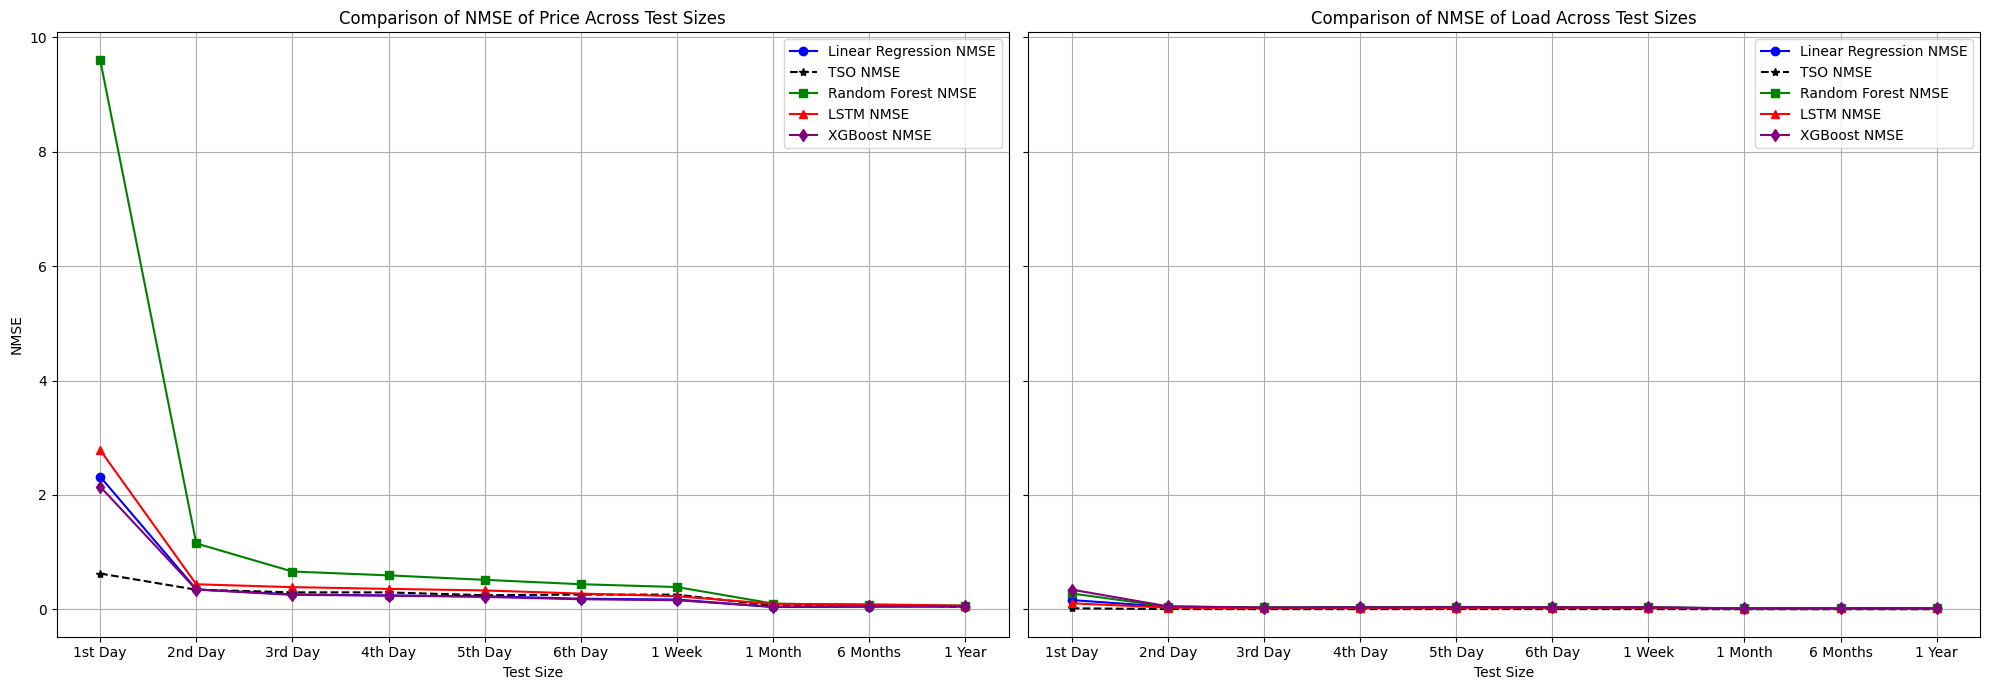

In [ ]:
import matplotlib.pyplot as plt

def compare_tso_with_both_models_line_plot(price_evaluation_results, load_evaluation_results):
    # Prepare the figure layout with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7), sharey=True)

    # Define common markers and colors
    markers = ['o', 's', '^', 'd', '*']
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    # Plot for price
    test_sizes = list(price_evaluation_results.keys())
    models = list(next(iter(price_evaluation_results.values())).keys())
    for i, model in enumerate(models):
        nmse_values = [price_evaluation_results[test_size][model]['NMSE'] for test_size in test_sizes]
        tso_nmse_values = [price_evaluation_results[test_size][model]['TSO_NMSE'] for test_size in test_sizes]
        ax1.plot(test_sizes, nmse_values, marker=markers[i % len(markers)], color=colors[i % len(colors)], label=f'{model} NMSE')
        if model == models[0]:  # Plot TSO NMSE once
            ax1.plot(test_sizes, tso_nmse_values, marker=markers[-1], color='black', linestyle='--', label='TSO NMSE')
    ax1.set_title('Comparison of NMSE of Price Across Test Sizes')
    ax1.set_xlabel('Test Size')
    ax1.set_ylabel('NMSE')
    ax1.legend()
    ax1.grid(True)

    # Plot for load
    test_sizes = list(load_evaluation_results.keys())
    models = list(next(iter(load_evaluation_results.values())).keys())
    for i, model in enumerate(models):
        nmse_values = [load_evaluation_results[test_size][model]['NMSE'] for test_size in test_sizes]
        tso_nmse_values = [load_evaluation_results[test_size][model]['TSO_NMSE'] for test_size in test_sizes]
        ax2.plot(test_sizes, nmse_values, marker=markers[i % len(markers)], color=colors[i % len(colors)], label=f'{model} NMSE')
        if model == models[0]:  # Plot TSO NMSE once
            ax2.plot(test_sizes, tso_nmse_values, marker=markers[-1], color='black', linestyle='--', label='TSO NMSE')
    ax2.set_title('Comparison of NMSE of Load Across Test Sizes')
    ax2.set_xlabel('Test Size')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


compare_tso_with_both_models_line_plot(price_evaluation_results, load_evaluation_results)
